# Data Wrangling<a id='Data_Wrangling'>

This notebook will take movie data, clean it, and explore the data to find some trends among the data. 

Data Source: https://www.kaggle.com/datasets/benjameeper/movie-violencesexprofanity-data?resource=download

## Table of Contents<a id='Table_of_Contents'>

* [Data Wrangling](#Data_Wrangling)
  * [Table of Contents](#Table_of_Contents)
  * [Imports](#Imports)
  * [Functions/Constants](#Functions)
      * [Functions](#Functions_sub)
      * [Constants](#Constants)
  * [Load The Data](#Load_the_Data)
  * [Clean the Data](#Clean_the_Data)
      * [tags](#tags)
      * [movies](#movies)
      * [movie_tags](#movie_tags)
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
    * [Movies](#Movies_EDA)
        * [Name](#Name)
        * [Year](#Year)
        * [Rating](#Rating)
        * [Duration](#Duration)
        * [Studios](#Studios)
        * [Number of Studios](#number_of_studios)
    * [Movie Tags](#Movie_Tags_EDA)
        * [Category](#Category)
        * [Tag Name](#tag_name)
        * [Occurrence Count](#occurrence_cnt)
        * [Duration (Seconds)](#duration_sec)
* [Save the Data](#Save_the_Data)

## Imports <a id='Imports'>

Here we will import all the necessary packages we will need. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re

## Functions/Constants <a id='Functions'>

Here we will define all of our functions and constants that we will need for this analysis. 

### Functions <a id='Functions_sub'>

Here are our functions that we will be using. These will mostly be used for common graphs that we will be using later in Exploratory Data Analysis. 

In [2]:
def plot_histogram_with_counts(data_frame, column_name, bin_edges=10, title="", title_suffix="",color=None):
    '''Plots a histogram of a specific column from a dataframe. 
    Includes the ability to add number of bins, titles, and colors. '''
    
    plt.clf()
    
    # Create the histogram
    hist, bin_edges, _ = plt.hist(data_frame[column_name], bins=bin_edges, alpha=0.7, color=color,edgecolor='black')

    # Display the count on each bar
    for i, count in enumerate(hist):
        plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, count, str(int(count)), ha='center', va='bottom')

    plt.xlabel(column_name.capitalize())
    plt.ylabel('Count')
    plt.title(title+title_suffix)
    plt.show()

In [3]:
def countplot_y(data,column,bars=10, hue=None,palette=None,title='',legend_title=None,legend=True):
    '''Plots a countplot horizontally for a specific column from a dataframe. 
    Can add hue, palettes, titles, and legends as needed.'''
    
    plt.clf()
    
    counts = data[column].value_counts().sort_values(ascending=False).nlargest(bars)
    
    
    ax = sns.countplot(y=column, data= data,order=counts.index,hue=hue,palette = palette)
    
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha = 'left', va = 'center')

    if legend:
        ax.legend(loc='lower right',title=legend_title)
    else:
        ax.legend_ = None
    
    plt.title(title)
    
    plt.show()

In [4]:
def countplot_x(data,column,bars=10, hue=None,palette=None,title='',legend_title=None,legend=True):
    '''Plots a countplot vertically for a specific column from a dataframe. 
    Can add hue, palettes, titles, and legends as needed.'''
    
    plt.clf()
    
    counts = data[column].str.strip().value_counts().sort_values(ascending=False).nlargest(bars)
    
    ax = sns.countplot(x=column, data=data, order=counts.index, hue=hue, palette = palette)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height() + 5), ha='center', va='bottom')

    if legend:
        ax.legend(loc='lower right', title=legend_title)
    else:
        ax.legend_ = None

    plt.title(title)
    
    plt.show()

In [5]:
# Function to find similar studio names
def find_similar_studios(target_studio, all_studios, threshold=95):
    '''This is a function to find similarly named studios.
    Uses a fuzzy score of 95 and will return all the studios and their similarities.'''
    
    similar_studios = process.extract(target_studio, all_studios, scorer=fuzz.partial_ratio)
    return [(studio, score) for studio, score in similar_studios if score >= threshold]

In [6]:
# Apply a function to each row to keep one instance of each value and replace the rest with None
def clean_duplicates(row):
    '''This function is used to cleanup the rows of a dataframe to have no duplicates and replaces them with None. 
    Is used in an apply method on a dataframe for each row.'''
    
    seen_values = set()
    new_row = []
    for item in row:
        if item is not None and item not in seen_values:
            seen_values.add(item)
            new_row.append(item)
        else:
            new_row.append(None)
    return new_row

### Constants <a id='Constants'>

Here we define our constants which include colors for consistency among our graphs for different Ratings and Categories. We also will be including our mapping that we will use later for cleaning up the studio names. 

Here is the dictionary for our rating colors. 

In [7]:
rating_colors = {
    'G': 'green',
    'PG': 'orange',
    'PG-13': 'gray',
    'R': 'brown',
    'NR': 'black',
    'TV-MA': 'red',
    'TV-14': 'pink',
    'TV-PG': 'yellow',
    'TV-G': 'lime',
    'TV-Y7': 'cyan'
}

Here is the dictionary for our category colors.

In [8]:
category_colors = {
    'language':'navy',
    'sexual':'hotpink',
    'violence':'maroon',
    'immodesty':'lightpink',
    'drugs':'gray',
    'other':'black'
}

Here is our mapping of all the studios that had duplicates of somekind. This was found in my Exploratory Data Analysis. I went through and mapped out in a dictionary what the name of the studio currently is, and what studio it will be included in to create a consistent studio name. 

In [9]:
#Map duplicate studios so they are more consistent across movies. 
studio_mapping = {
    'Amazon': 'Amazon Studios',
    'Paramount Pictures': 'Paramount', 
    'Paramount Players':'Paramount', 
    'Paramount Vantage':'Paramount', 
    'Paramount Pictures Corporation':'Paramount',
    'Paramount Pictures International':'Paramount',
    'Don Simpson/Jerry Bruckheimer Films':'Jerry Bruckheimer Films',
    'Summit entertainment':'Summit Entertainment',
    'Universal PIctures':'Universal Pictures',
    'Universal 1440 Entertainment':'Universal Pictures',
    'Universal':'Universal Pictures',
    'verture Films':'Overture Films',
    'Participant Media':'Participant',
    'di Bonaventura Pictures':'Di Bonaventura Pictures',
    'Skydance Sports':'Skydance', 
    'Skydance Media': 'Skydance', 
    'Skydance Animation':'Skydance',
    'Pioneer Stilking Films':'Stillking Films',
    '87Eleven':'87Eleven Productions',
    'Apple':'Apple Studios',
    'Apple Inc.':'Apple Studios',
    'dentsu':'Dentsu',
    'DENTSU':'Dentsu',
    'Lord Miller':'Lord Miller Productions',
    'Blur Studio':'Blur Studios',
    'Netflix Animation':'Netflix',
    'Netflix Studios':'Netflix',
    'netflix':'Netflix',
    'Netflix International Pictures':'Netflix',
    'Lions Gate Entertainment':'Lions Gate',
    'Lions Gate Films Inc':'Lions Gate',
    'Lions Gate Films':'Lions Gate',
    'Lionsgate':'Lions Gate',
    'Carnival Films & Television':'Carnival Films',
    'Sony Pictures':'Sony',
    'Sony Pictures Animation':'Sony',
    'Sony Pictures Television':'Sony',
    'Sony Pictures Imageworks':'Sony',
    'Sony Pictures Classics':'Sony',
    'Sony Music Entertainment (Japan)':'Sony',
    'Metro-Goldwyn-Mayer (MGM)':'MGM',
    'MGM Television':'MGM',
    'Columbia Pictures':'Columbia',
    'Columbia Pictures Industries':'Columbia',
    'DreamWorks Animation':'DreamWorks',
    'DreamWorks Pictures':'DreamWorks',
    'Dreamworks Pictures':'DreamWorks',
    'DreamWorks II Distribution Co., LLC':'DreamWorks',
    'Dreamworks':'DreamWorks',
    'DreamWorks Animation L.L.C.':'DreamWorks',
    'IAC Films [US]':'IAC Films',
    'Eclectic pictures':'Eclectic Pictures',
    'Thunder Road':'Thunder Road Pictures',
    'StudioCanal':'Canal+',
    'Studio Canal':'Canal+',
    'Atresmedia':'Atresmedia Cine',
    'Anchor Bay Entertainment':'Anchor Bay',
    'Nolita':'Nolita Cinema',
    'Highland Film Group (HFG)':'Highland Film Group',
    'Global Entertainment Productions GmbH & Company Medien KG':'Global Entertainment Productions',
    'Focus Features':'Focus',
    'Focus Features International (FFI)':'Focus',
    'Focus World':'Focus',
    'Motion Picture Corporation of America (MPCA)':'Motion Picture Corporation of America',
    'Cinesite Animation':'Cinesite',
    'Mockingbird Pirctures':'Mockingbird Pictures',
    'EO':'Levitate Film',
    'Tri-Star Pictures, inc':'Tri Star',
    'BBC Film':'BBC',
    'BBC Studios':'BBC',
    'BBC Films':'BBC',
    'IFC Films':'IFC',
    'IFC Midnight':'IFC',
    'Street Entertainment':'10th Street Entertainment',
    'The Weinstein Company':'Weinstein Company',
    'Pure Flix Entertainment':'Pure Flix',
    'Pathe':'Pathe Productions',
    'Radar Pictures Inc.':'Radar Pictures',
    'Danjaq':'Danjaq, LLC',
    'Film4':'Film4 Productions',
    'uMedia':'Umedia',
    'The Hallmark Channel':'Hallmark',
    'Hanway Films':'HanWay Films',
    'Bona Fide':'Bona Fide Productions',
    'VidAngel Studios':'Angel Studios',
    'Northern Lights Film':'Northern Lights Films',
    'Pantelion Film':'Pantelion Films'
}

## Load the Data <a id='Load_the_Data'>

Let's load the data for our three dataframes. 

In [10]:
tags = pd.read_csv('data/raw_data/tags.csv')
movies = pd.read_csv('data/raw_data/movies.csv')
movie_tags = pd.read_csv('data/raw_data/movie_tags.csv')

## Clean the Data <a id='Clean_the_Data'>

Let's now clean the data, starting with the tags dataframe. 

### tags <a id='tags'>

Let's first view the dataframe and see what it looks like and if anything needs to be cleaned. 

In [11]:
pd.set_option('display.max_colwidth', None)
tags

,category,tag_name,title,description
0,language,profanity,Profanity,NaN
1,language,blasphemy,Blasphemy,NaN
2,language,sexual_reference,Sexual References and Innuendos,"Any references or jokes about sex, flirting, innuendos, etc."
3,language,childish_language,Childish Language,"Generally, things you would not want your 3-year-old to repeat."
4,language,racial_slurs,Racial Slurs and Bigoted Language,"Racist, sexist, and/or discriminatory language in any form."
5,violence,non_graphic,Non-Graphic,Violence without blood.
6,violence,graphic,Graphic,Violence with blood or breaking bones.
7,violence,disturbing_images,Disturbing Images,"Dead bodies, severed body parts, or object protruding from body"
8,violence,gore,Gore,"Gore, bloody guts, bloody severed body parts."
9,violence,violence_implied,Implied Violence,The violence is not seen on screen. Graphic descriptions or details of a violent act.


We see there are a couple of tags of NaN as the description. However, we won't be using the description in any analysis so we will leave them as NaN. 

I will be adding a new row to the tags for 'Other' to be able to account for anything that is not already listed in this tag list. It won't need to be used in this analysis, but wanted to include it in case it was ever needed for any new data that did not fall under any of these tags. 

In [12]:
#Add an other tag_name under the other category to be able to capture anything that does not already have a specific tag.
new_row = pd.DataFrame({'category': ['other'], 'tag_name': ['other'],'title': ['Other']})

tags = pd.concat([tags, new_row], ignore_index=True)

tags


,category,tag_name,title,description
0,language,profanity,Profanity,NaN
1,language,blasphemy,Blasphemy,NaN
2,language,sexual_reference,Sexual References and Innuendos,"Any references or jokes about sex, flirting, innuendos, etc."
3,language,childish_language,Childish Language,"Generally, things you would not want your 3-year-old to repeat."
4,language,racial_slurs,Racial Slurs and Bigoted Language,"Racist, sexist, and/or discriminatory language in any form."
5,violence,non_graphic,Non-Graphic,Violence without blood.
6,violence,graphic,Graphic,Violence with blood or breaking bones.
7,violence,disturbing_images,Disturbing Images,"Dead bodies, severed body parts, or object protruding from body"
8,violence,gore,Gore,"Gore, bloody guts, bloody severed body parts."
9,violence,violence_implied,Implied Violence,The violence is not seen on screen. Graphic descriptions or details of a violent act.


We see that the Other row has been added, so we should be good to proceed to the next dataframe, movies. 

### movies <a id='movies'>

Let's first view the movies dataframe and see what it looks like. 

In [13]:
pd.reset_option('display.max_colwidth')
movies

,imdb_id,name,title_main,title_subscript,year,mpaa_rating,duration_sec,studio
0,tt11274492,The Out-Laws,The Out-Laws,NaN,2023,R,5700,Happy Madison Productions
1,tt12263384,Extraction 2,Extraction 2,NaN,2023,R,7380,Filmhaus Films|AGBO
2,tt16419074,Air,Air,NaN,2023,R,6720,Mandalay Pictures|Amazon Studios|Skydance Spor...
3,tt14400246,Bird Box Barcelona,Bird Box Barcelona,NaN,2023,TV-MA,7440,Nostromo Pictures|Bluegrass Films|Chris Morgan...
4,tt1745960,Top Gun: Maverick,Top Gun: Maverick,NaN,2022,PG-13,7860,Paramount|Jerry Bruckheimer Films|Don Simpson/...
...,...,...,...,...,...,...,...,...
1729,tt6902676,Guns Akimbo,Guns Akimbo,NaN,2020,R,5700,Ingenious Media|Occupant Films|Four Knights Fi...
1730,tt3813310,Cop Car,Cop Car,NaN,2015,R,5280,Universal
1731,tt2091935,Mr. Right,Mr. Right,NaN,2016,R,5700,Focus World
1732,tt13372794,The Manor,The Manor,NaN,2021,TV-MA,4860,Amazon Studios|Blumhouse Television


Some potential things we will need to look at are the null values in the title_subscript and see how that relates to the title_main column. We'll also want to look for any dupliacte movies, movies that have the same name, as well as explore the studios for any duplicates/changes to make. Let's see the datatypes of the columns. 

In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   imdb_id          1734 non-null   object
 1   name             1734 non-null   object
 2   title_main       1734 non-null   object
 3   title_subscript  32 non-null     object
 4   year             1734 non-null   int64 
 5   mpaa_rating      1734 non-null   object
 6   duration_sec     1734 non-null   int64 
 7   studio           1734 non-null   object
dtypes: int64(2), object(6)
memory usage: 108.5+ KB


We see that all the datatypes are what we would expect, so no adjustments are needed there. We also see the only column with missing values is that title_subscript column. Let's find all movies that have a title subscript populated. 

In [15]:
subscript_movies = movies[movies.title_subscript > ""]

subscript_movies

,imdb_id,name,title_main,title_subscript,year,mpaa_rating,duration_sec,studio
39,tt1229238,Mission: Impossible IV: Ghost Protocol,Mission: Impossible IV,Ghost Protocol,2011,PG-13,7980,Paramount Pictures
56,tt2368619,Bastille Day: The Take,Bastille Day,The Take,2016,R,5520,StudioCanal
76,tt0103064,Terminator 2: Judgment Day,Terminator 2,Judgment Day,1991,R,8220,Lions Gate Entertainment
177,tt1590193,The Commuter: Lives are on the line,The Commuter,Lives are on the line,2018,PG-13,6240,StudioCanal
244,tt9742794,The Vault: aka Way Down,The Vault,aka Way Down,2021,R,7080,Telecinco Cinema|Think Studio|Saban Films|Ciud...
245,tt2250912,Spider-Man: Homecoming: Theatrical Version,Spider-Man: Homecoming,Theatrical Version,2017,PG-13,7980,Columbia Pictures Industries
290,tt4106376,American Renegades: (aka Renegades),American Renegades,(aka Renegades),2017,PG-13,6300,Studio Babelsberg
345,tt4514646,Tim Timmerman: Hope of America,Tim Timmerman,Hope of America,2017,PG-13,5916,VidAngel Studios
412,tt5536736,The Meyerowitz Stories: New and Selected,The Meyerowitz Stories,New and Selected,2017,TV-MA,6720,IAC Films
422,tt9657544,Jim Gaffigan: Quality Time,Jim Gaffigan,Quality Time,2019,PG-13,4500,Comedy Dynamics


Looking at the list, it appears the title_subtitle column takes the name of the movie and if there exists a ':', it substrings the title where anything before the ':' is the title and anything after is the subtitle. Let's now check to see if any duplicate title_mains exist in the original movies dataframe.

In [16]:
#The resulting check_dups_df DataFrame will contain all rows from the movies DataFrame where the 'title_main' 
#value matches one of the unique 'title_main' values in subscript_movies, which effectively shows you which 
#entries in movies have duplicates based on the 'title_main' column.

check_dups = []

for title in subscript_movies['title_main']:
    result = movies[movies['title_main'] == title]
    check_dups.append(result)

check_dups_df = pd.concat(check_dups, ignore_index=True).sort_values(by='name')
check_dups_df

,imdb_id,name,title_main,title_subscript,year,mpaa_rating,duration_sec,studio
23,tt5503688,6 Below: Miracle on the Mountain,6 Below,Miracle on the Mountain,2017,PG-13,5820,Dune Entertainment
6,tt4106376,American Renegades: (aka Renegades),American Renegades,(aka Renegades),2017,PG-13,6300,Studio Babelsberg
1,tt2368619,Bastille Day: The Take,Bastille Day,The Take,2016,R,5520,StudioCanal
28,tt4230700,Complete Unknown: Identities,Complete Unknown,Identities,2016,R,5460,Parts and Labor
26,tt3317234,"Game Over, Man!: Game Over, Man!","Game Over, Man!","Game Over, Man!",2018,TV-MA,6060,Point Grey Pictures
12,tt5052448,Get Out: (with alternate ending),Get Out,(with alternate ending),2017,R,6240,Universal Pictures
24,tt10665338,Halloween Kills: Extended Cut,Halloween Kills,Extended Cut,2021,TV-MA,6300,Lionsgate
20,tt5726086,Insidious: The Last Key,Insidious,The Last Key,2018,PG-13,6180,Stage 6 Films
19,tt2908446,Insurgent: Insurgent,Insurgent,Insurgent,2015,PG-13,7140,Universal
9,tt9657544,Jim Gaffigan: Quality Time,Jim Gaffigan,Quality Time,2019,PG-13,4500,Comedy Dynamics


In [17]:
check_dups_df[check_dups_df.duplicated()]

,imdb_id,name,title_main,title_subscript,year,mpaa_rating,duration_sec,studio


Not seeing any duplicates for all titles that exist so seems like title_main and title_subscript may not be needed since the name column should have the accurate movie title with no duplicates. Let's now check for duplicates for all movies. 

In [18]:
movies[movies.duplicated()]

,imdb_id,name,title_main,title_subscript,year,mpaa_rating,duration_sec,studio


No current duplicates. Let's drop those two columns since all we will need is the name of the movie. 

In [19]:
movies.drop(['title_main','title_subscript'], axis=1, inplace=True)

I also found in later analysis that there was an issue with commas in some of the studio names. For example, the movie White Boy Rick includes 'Protozoa Pictures, Studio 8' as one of the studios, but that comma really should have been a | to separate them. Here I am updating the values properly so it won't cause issues in the analysis later on. 

In [20]:
pd.set_option('display.max_colwidth', None)
comma_studios = movies[movies['studio'].str.contains(',', na=False)]
comma_studios

,imdb_id,name,year,mpaa_rating,duration_sec,studio
264,tt1817273,The Place Beyond the Pines,2013,R,8400,"Kimmel Distribution, LLC"
288,tt4633694,Spider-Man: Into the Spider-Verse,2018,PG,7020,"Columbia Pictures, Sony Pictures, Sony Pictures Animation"
291,tt0071853,Monty Python and the Holy Grail,1975,PG,5460,"National Film Trustee Company, Ltd."
342,tt0083944,Rambo: First Blood,1982,R,5580,"Anabasis Investments, N.V."
366,tt1454029,The Help,2011,PG-13,8760,"DreamWorks II Distribution Co., LLC"
371,tt4034228,Manchester by the Sea,2016,R,8280,"KFilms Manchester, LLC"
445,tt6107548,Late Night,2019,R,6120,"Late Night Distribution, LLC"
499,tt8400584,The Perfect Find,2023,R,5940,"Confluential Films|AGC Studios|I’ll Have Another|HR Entertainment, Inc."
660,tt1972779,The Best of Me,2014,PG-13,7020,"Best of Me Productions, LLC"
809,tt0892767,Horsemen,2009,R,5400,"Horsemen Productions, LLC"


After a bit of research into the studio for the movie "Abandon", the full name of the studio is 'MFP Munich Film Partners New Century, GMBH & Co. Ham Productions KG', and that is a unique studio so I will leave that one as is. Later on, we will change any unique studios to 'Other' so we don't mess with our analysis later on. Let's update the other studios that needed to be updated. 

In [21]:
wbr = movies[movies['imdb_id'] == 'tt4537896'] 
spider = movies[movies['imdb_id'] == 'tt4633694']
peewee = movies[movies['imdb_id'] == 'tt0837156']

movies.loc[wbr.index, 'studio'] = 'Columbia Pictures|Protozoa Pictures|Studio 8'
movies.loc[spider.index, 'studio'] = 'Columbia Pictures|Sony Pictures|Sony Pictures Animation'
movies.loc[peewee.index, 'studio'] = 'SYOSSET PRODUCTIONS, INC.|PEE-WEE HERMAN PRODUCTIONS, INC.'

In [22]:
selected_ids = ['tt4537896', 'tt4633694', 'tt0837156']
movies[movies['imdb_id'].isin(selected_ids)] 

,imdb_id,name,year,mpaa_rating,duration_sec,studio
288,tt4633694,Spider-Man: Into the Spider-Verse,2018,PG,7020,Columbia Pictures|Sony Pictures|Sony Pictures Animation
1432,tt0837156,Pee-Wee's Big Holiday,2016,PG,5400,"SYOSSET PRODUCTIONS, INC.|PEE-WEE HERMAN PRODUCTIONS, INC."
1631,tt4537896,White Boy Rick,2018,R,6660,Columbia Pictures|Protozoa Pictures|Studio 8


The studios for these three movies are now corrected. We can proceed with looking at the studio column. 

In [23]:
pd.reset_option('display.max_colwidth')
movies

,imdb_id,name,year,mpaa_rating,duration_sec,studio
0,tt11274492,The Out-Laws,2023,R,5700,Happy Madison Productions
1,tt12263384,Extraction 2,2023,R,7380,Filmhaus Films|AGBO
2,tt16419074,Air,2023,R,6720,Mandalay Pictures|Amazon Studios|Skydance Spor...
3,tt14400246,Bird Box Barcelona,2023,TV-MA,7440,Nostromo Pictures|Bluegrass Films|Chris Morgan...
4,tt1745960,Top Gun: Maverick,2022,PG-13,7860,Paramount|Jerry Bruckheimer Films|Don Simpson/...
...,...,...,...,...,...,...
1729,tt6902676,Guns Akimbo,2020,R,5700,Ingenious Media|Occupant Films|Four Knights Fi...
1730,tt3813310,Cop Car,2015,R,5280,Universal
1731,tt2091935,Mr. Right,2016,R,5700,Focus World
1732,tt13372794,The Manor,2021,TV-MA,4860,Amazon Studios|Blumhouse Television


Let's look at the current count of studios as they currently are. 

In [24]:
movies['studio'].describe()

count          1734
unique          936
top       Universal
freq            180
Name: studio, dtype: object

We see there are 936 unique studios, but for a lot of them, that is a unique combination when having multiple studios separated by |'s. Let's see how many studios contain a | which signifies there were multiple studios.

In [25]:
pipe_studios = movies[movies['studio'].str.contains('\|', na=False)]

pipe_studios

,imdb_id,name,year,mpaa_rating,duration_sec,studio
1,tt12263384,Extraction 2,2023,R,7380,Filmhaus Films|AGBO
2,tt16419074,Air,2023,R,6720,Mandalay Pictures|Amazon Studios|Skydance Spor...
3,tt14400246,Bird Box Barcelona,2023,TV-MA,7440,Nostromo Pictures|Bluegrass Films|Chris Morgan...
4,tt1745960,Top Gun: Maverick,2022,PG-13,7860,Paramount|Jerry Bruckheimer Films|Don Simpson/...
6,tt8936646,Extraction,2020,R,6960,India Take One Productions|T.G.I.M. Films|AGBO...
...,...,...,...,...,...,...
1720,tt6662736,What They Had,2018,R,6060,Bona Fide Productions|United Pictures|June Pic...
1727,tt3628574,State Like Sleep,2019,R,6300,3311 Productions|Scythia Films|Code Red Produc...
1728,tt7074886,The Front Runner,2018,R,6780,Bron Studios|Right of Way Films|Creative Wealt...
1729,tt6902676,Guns Akimbo,2020,R,5700,Ingenious Media|Occupant Films|Four Knights Fi...


There are 504 rows with multiple studios, so let's split them out and see how many total studios were included in all these fields. 

In [26]:
piped_studios_concatenated = '|'.join(pipe_studios['studio'].dropna())
unique_studios = set(piped_studios_concatenated.split('|'))
len(unique_studios)

1084

There are 1084 studios hiding between the 504 rows. Let's get a count of each unique studio.

In [27]:
studio_counts = Counter(piped_studios_concatenated.split('|'))

sorted_studio_counts = sorted(studio_counts.items(), key=lambda x: x[1], reverse=True)

for studio, count in sorted_studio_counts:
    print(f"Studio: {studio}, Count: {count}")

Studio: Universal Pictures, Count: 34
Studio: Columbia Pictures, Count: 26
Studio: Amazon Studios, Count: 25
Studio: Paramount, Count: 20
Studio: Sony Pictures, Count: 15
Studio: Lionsgate, Count: 14
Studio: Bron Studios, Count: 14
Studio: Ingenious Media, Count: 13
Studio: Blumhouse Productions, Count: 12
Studio: Netflix, Count: 12
Studio: FilmNation Entertainment, Count: 12
Studio: Focus Features, Count: 10
Studio: Working Title Films, Count: 9
Studio: A24, Count: 9
Studio: Skydance Media, Count: 8
Studio: Perfect World Pictures, Count: 8
Studio: Metro-Goldwyn-Mayer, Count: 8
Studio: Original Film, Count: 8
Studio: Film4 Productions, Count: 8
Studio: Endeavor Content, Count: 8
Studio: StudioCanal, Count: 8
Studio: Creative Wealth Media Finance, Count: 8
Studio: BBC Films, Count: 8
Studio: Anonymous Content, Count: 7
Studio: XYZ Films, Count: 7
Studio: Plan B Entertainment, Count: 7
Studio: AGBO, Count: 6
Studio: Amblin Entertainment, Count: 6
Studio: Entertainment One, Count: 6
Studi

We see that the count of each individual studio is relatively low (with a lot of unique studios), but they would still count toward our totals potentially, so it'll still be important to split them out. Let's order alphabetically to see if there are any that could maybe be combined together. 

In [28]:
piped_studios_concatenated = '|'.join(pipe_studios['studio'].dropna())
studio_counts = Counter(piped_studios_concatenated.split('|'))

sorted_studio_counts = sorted(studio_counts.items(), key=lambda x: (x[0]))

for studio, count in sorted_studio_counts:
    print(f"Studio: {studio}, Count: {count}")

Studio: 10th Street Entertainment, Count: 1
Studio: 1212 Entertainment, Count: 1
Studio: 13 Films, Count: 1
Studio: 1492 Pictures, Count: 1
Studio: 17-28 Black Production, Count: 1
Studio: 199 Productions, Count: 1
Studio: 2.0 Entertainment, Count: 1
Studio: 21 Laps Entertainment, Count: 2
Studio: 22h22, Count: 1
Studio: 24 25 Films, Count: 1
Studio: 2DUX², Count: 1
Studio: 3 Arts Entertainment, Count: 1
Studio: 3000 Pictures, Count: 1
Studio: 308 Enterprises, Count: 1
Studio: 30WEST, Count: 4
Studio: 3311 Productions, Count: 1
Studio: 3QU Media, Count: 2
Studio: 3dot Productions, Count: 2
Studio: 40 Acres & A Mule Filmworks, Count: 1
Studio: 42, Count: 1
Studio: 5000 Broadway Productions, Count: 1
Studio: 5150 Action, Count: 1
Studio: 87Eleven, Count: 2
Studio: 87Eleven Productions, Count: 1
Studio: 87North Productions, Count: 3
Studio: 9 Light Entertainment, Count: 1
Studio: A Band Apart, Count: 1
Studio: A Contracorriente Films, Count: 1
Studio: A-Line Pictures, Count: 1
Studio: A.U

We see that there are some studios that are being counted as unique right now that probably should be combined. Let's do some string comparison among all studios (piped or not) so we can get them combined. 

We will use some functions in fuzzywuzzy to get scores and find similar studios. We will be using a unique threshold of 95 so we only get very close results. First we will split the movies up into the split variable which will contain all movie studios, including both those that are split by pipes, and those that are not. Then we will add them to a dictionary that will contain the studio name, then all the similar studios that were at least 95 percent similar. We will then put the results in a dictionary and display the results. 

In [29]:
split = movies['studio'].str.split('|', expand=True).stack().unique()

# Create a dictionary to store similar studio names
similar_studio_dict = {}

# Loop through each studio in split
for studio in split:
    similar_studios = find_similar_studios(studio, split)
    if len(similar_studios) >= 1:
        similar_studio_dict[studio] = [similar_studio for similar_studio, _ in similar_studios]

# Print the similar studio names
for studio, similar_studios in similar_studio_dict.items():
    print(f"Studio: {studio}")
    print(f"Similar Studios: {', '.join(similar_studios)}")
    print()

Studio: Happy Madison Productions
Similar Studios: Happy Madison Productions

Studio: Filmhaus Films
Similar Studios: Filmhaus Films

Studio: AGBO
Similar Studios: AGBO

Studio: Mandalay Pictures
Similar Studios: Mandalay Pictures

Studio: Amazon Studios
Similar Studios: Amazon Studios, Amazon

Studio: Skydance Sports
Similar Studios: Skydance Sports, Skydance

Studio: Artists Equity
Similar Studios: Artists Equity

Studio: Nostromo Pictures
Similar Studios: Nostromo Pictures

Studio: Bluegrass Films
Similar Studios: Bluegrass Films

Studio: Chris Morgan Productions
Similar Studios: Chris Morgan Productions

Studio: Dylan Clark Productions
Similar Studios: Dylan Clark Productions

Studio: Paramount
Similar Studios: Paramount, Paramount Pictures, Paramount Players, Paramount Vantage, Paramount Pictures Corporation

Studio: Jerry Bruckheimer Films
Similar Studios: Jerry Bruckheimer Films, Don Simpson/Jerry Bruckheimer Films

Studio: Don Simpson/Jerry Bruckheimer Films
Similar Studios: Je

With this list, I was able to sort through it and create the mapping of studios that should be grouped together. For example, 'Amazon Studios' had a similar studio to it called 'Amazon'. I compiled these values and sorted through them to determine if there were any that needed to be mapped differently to be more consistent across films. It's possible my mapping is not perfect, but it allows companies under the same umbrella to be represented together. There could be an argument made against doing that, but for this analysis, we will see it through. 

In order to help with the analysis to create the mapping, I created the below code block to help me find specific studios which allowed me to see what the row looks like in regards to different studios. The example below is showing anything that includes "Right of Way Films" as the studio, but can be used with any studio I want to look up. 

In [30]:
check_movies = movies['studio'].str.split('|', expand=True)

target_studio = "Right of Way Films"
studio_found_mask = check_movies.applymap(lambda cell: target_studio in str(cell))

# Find rows where the target studio was found in any of the columns
matching_rows = studio_found_mask.any(axis=1)

# Filter the DataFrame to get the rows where the studio was found
result = check_movies[matching_rows]

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1728,Bron Studios,Right of Way Films,Creative Wealth Media Finance,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


I also could look up the name of the movie in the original dataframe to see what the original data looked like. Here is the movie 'The Front Runner' that is a film that had Right of Way Films as one of the studios. 

In [31]:
movies[movies['name'] == 'The Front Runner'] 

,imdb_id,name,year,mpaa_rating,duration_sec,studio
1728,tt7074886,The Front Runner,2018,R,6780,Bron Studios|Right of Way Films|Creative Wealt...


With the mapping created and stored in the variable studio_mapping (see constants section for the full mapping), let's take a look at all the possible studios, as well as their rating so we can get the values updated. To do this, we will take all the movie studios and expand them in a dataframe where the name of the movies is the index, columns 0-17 are all the studios associated to the movie, and the mpaa_rating of the movie is included as well in the last column. 

In [32]:
split_studios = movies['studio'].str.split('|', expand=True)
split_studios = split_studios.applymap(lambda x: x.strip() if isinstance(x, str) else x)
split_studios['mpaa_rating'] = movies['mpaa_rating']
split_studios.index= movies.name
split_studios

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,mpaa_rating
name,,,,,,,,,,,,,,,,,,,
The Out-Laws,Happy Madison Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Extraction 2,Filmhaus Films,AGBO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Air,Mandalay Pictures,Amazon Studios,Skydance Sports,Artists Equity,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Bird Box Barcelona,Nostromo Pictures,Bluegrass Films,Chris Morgan Productions,Dylan Clark Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,TV-MA
Top Gun: Maverick,Paramount,Jerry Bruckheimer Films,Don Simpson/Jerry Bruckheimer Films,TC Productions,Tencent Pictures,Skydance Media,None,None,None,None,None,None,None,None,None,None,None,None,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guns Akimbo,Ingenious Media,Occupant Films,Four Knights Film,Altitude Film Entertainment,Hyperion Media Group,The Electric Shadow Company,Maze Pictures,Pump Metal Films,None,None,None,None,None,None,None,None,None,None,R
Cop Car,Universal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Mr. Right,Focus World,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R


We then want to iterate through each value and replace anything that is in the mapping. For example, one of the mapping pairs was Jerry Bruckheimer Films and Don Simpson/Jerry Bruckheimer Films. Since these are essentially the same company, the mapping will replace one of them to be the same as the other so they can be grouped together. In this case, Don Simpson/Jerry Bruckheimer Films will be changed to Jerry Bruckheimer Films. 

In [33]:
# Iterate through each row in the DataFrame
for index, row in split_studios.iterrows():
    for col in range(18):  # Columns 0-17
        # Get the value in the current cell
        value = row[col]
        
        # If the value is in the studio_mapping, replace it
        if value in studio_mapping:
            split_studios.at[index, col] = studio_mapping[value]

split_studios

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,mpaa_rating
name,,,,,,,,,,,,,,,,,,,
The Out-Laws,Happy Madison Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Extraction 2,Filmhaus Films,AGBO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Air,Mandalay Pictures,Amazon Studios,Skydance,Artists Equity,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Bird Box Barcelona,Nostromo Pictures,Bluegrass Films,Chris Morgan Productions,Dylan Clark Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,TV-MA
Top Gun: Maverick,Paramount,Jerry Bruckheimer Films,Jerry Bruckheimer Films,TC Productions,Tencent Pictures,Skydance,None,None,None,None,None,None,None,None,None,None,None,None,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guns Akimbo,Ingenious Media,Occupant Films,Four Knights Film,Altitude Film Entertainment,Hyperion Media Group,The Electric Shadow Company,Maze Pictures,Pump Metal Films,None,None,None,None,None,None,None,None,None,None,R
Cop Car,Universal Pictures,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Mr. Right,Focus,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R


Now that we have mapped everything, we are going to check the values again to see if there are any duplicates now that we have replaced some studio names. We see one with Top Gun: Maverick with Jerry Bruckheimer Films listed twice, so we will need to handle duplicates like that. If there are any duplicates, we will replace them with None. 

In [34]:
# Create a new DataFrame with the cleaned values
split_studios_cleaned_df = split_studios.apply(clean_duplicates, axis=1)
split_studios_cleaned_df = pd.DataFrame(split_studios_cleaned_df.tolist(), index=split_studios_cleaned_df.index, columns=split_studios.columns)

split_studios_cleaned_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,mpaa_rating
name,,,,,,,,,,,,,,,,,,,
The Out-Laws,Happy Madison Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Extraction 2,Filmhaus Films,AGBO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Air,Mandalay Pictures,Amazon Studios,Skydance,Artists Equity,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Bird Box Barcelona,Nostromo Pictures,Bluegrass Films,Chris Morgan Productions,Dylan Clark Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,TV-MA
Top Gun: Maverick,Paramount,Jerry Bruckheimer Films,None,TC Productions,Tencent Pictures,Skydance,None,None,None,None,None,None,None,None,None,None,None,None,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guns Akimbo,Ingenious Media,Occupant Films,Four Knights Film,Altitude Film Entertainment,Hyperion Media Group,The Electric Shadow Company,Maze Pictures,Pump Metal Films,None,None,None,None,None,None,None,None,None,None,R
Cop Car,Universal Pictures,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Mr. Right,Focus,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R


The last thing we need to do before converting these back is take any studios that show up 2 times or less, and replace them as 'Other'. We want to do this for analysis purposes so the system doesn't automatically predict the rating if a movie matches the studio exactly as studios do have the ability to make different ratings for movies. 

In [35]:
#Need to update unique studios to other

# Flatten the DataFrame into a Series and find studio counts
studio_counts = split_studios_cleaned_df.stack().value_counts()

# Replace studios that appear only once with 'Other'
for studio, count in studio_counts.items():
    if count <= 2:
        split_studios_cleaned_df = split_studios_cleaned_df.replace(studio, 'Other')

In [36]:
split_studios_cleaned_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,mpaa_rating
name,,,,,,,,,,,,,,,,,,,
The Out-Laws,Happy Madison Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Extraction 2,Other,AGBO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Air,Mandalay Pictures,Amazon Studios,Skydance,Other,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Bird Box Barcelona,Nostromo Pictures,Other,Other,Other,None,None,None,None,None,None,None,None,None,None,None,None,None,None,TV-MA
Top Gun: Maverick,Paramount,Jerry Bruckheimer Films,None,Other,Tencent Pictures,Skydance,None,None,None,None,None,None,None,None,None,None,None,None,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guns Akimbo,Ingenious Media,Other,Other,Other,Other,Other,Other,Other,None,None,None,None,None,None,None,None,None,None,R
Cop Car,Universal Pictures,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Mr. Right,Focus,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R


One thing to notice is that some movies may have 'Other' filled in multiple times. This would still be valid data based on filling in unique or nearly unique studio names, so we want to keep them as is for this analysis. 

Let's now convert the 'studios' column of our movies dataframe to an updated version with our newly mapped studios. We will separate them with a | again like it was originally and then in our Preprocessing step, we will split out the studios again and create dummy variables. We will also add a column with number of studios to see if that gives any information as well regarding rating. 

The first thing we will do is make a copy of our original movies dataframe. 

In [37]:
cleaned_movies_df = movies.copy()
cleaned_movies_df

,imdb_id,name,year,mpaa_rating,duration_sec,studio
0,tt11274492,The Out-Laws,2023,R,5700,Happy Madison Productions
1,tt12263384,Extraction 2,2023,R,7380,Filmhaus Films|AGBO
2,tt16419074,Air,2023,R,6720,Mandalay Pictures|Amazon Studios|Skydance Spor...
3,tt14400246,Bird Box Barcelona,2023,TV-MA,7440,Nostromo Pictures|Bluegrass Films|Chris Morgan...
4,tt1745960,Top Gun: Maverick,2022,PG-13,7860,Paramount|Jerry Bruckheimer Films|Don Simpson/...
...,...,...,...,...,...,...
1729,tt6902676,Guns Akimbo,2020,R,5700,Ingenious Media|Occupant Films|Four Knights Fi...
1730,tt3813310,Cop Car,2015,R,5280,Universal
1731,tt2091935,Mr. Right,2016,R,5700,Focus World
1732,tt13372794,The Manor,2021,TV-MA,4860,Amazon Studios|Blumhouse Television


Now we will loop through each row of our cleaned up studios dataframe and concatenate anything with mutliple studios with |'s. Lastly, we will add the column "number_of_studios" as another column so we can see how many studios a movie has. 

In [38]:
# Loop through each row in split_studios_cleaned_df
for index, row in split_studios_cleaned_df.iterrows():
    # Convert the non-None row values (excluding 'mpaa_rating') to a list of strings
    row_studios = [str(value) for value in row.drop('mpaa_rating') if value is not None]
    
    # Concatenate the strings with '|' separator
    concatenated_studios = '|'.join(row_studios)
    
    # Get the corresponding indices in cleaned_movies_df using the 'name' value
    movie_indices = cleaned_movies_df.index[cleaned_movies_df['name'] == index]
    
    # Update the 'studio' column in cleaned_movies_df for each matching index
    for movie_index in movie_indices:
        cleaned_movies_df.at[movie_index, 'studio'] = concatenated_studios

# Add column number_of_studios to the data
cleaned_movies_df['number_of_studios'] = cleaned_movies_df['studio'].apply(lambda x: x.count('|') + 1)

# Print the modified cleaned_movies_df DataFrame
cleaned_movies_df

,imdb_id,name,year,mpaa_rating,duration_sec,studio,number_of_studios
0,tt11274492,The Out-Laws,2023,R,5700,Happy Madison Productions,1
1,tt12263384,Extraction 2,2023,R,7380,Other|AGBO,2
2,tt16419074,Air,2023,R,6720,Other|Skydance,2
3,tt14400246,Bird Box Barcelona,2023,TV-MA,7440,Nostromo Pictures|Other|Other|Other,4
4,tt1745960,Top Gun: Maverick,2022,PG-13,7860,Paramount|Jerry Bruckheimer Films|Other|Tencen...,5
...,...,...,...,...,...,...,...
1729,tt6902676,Guns Akimbo,2020,R,5700,Ingenious Media|Other|Other|Other|Other|Other|...,8
1730,tt3813310,Cop Car,2015,R,5280,Universal Pictures,1
1731,tt2091935,Mr. Right,2016,R,5700,Focus,1
1732,tt13372794,The Manor,2021,TV-MA,4860,Amazon Studios|Blumhouse Television,2


We have now cleaned up our movies dataframe and added the number of studios as well. 

### movie_tags <a id='movie_tags'>

Let's now take a look at the movie_tags. This is a dataframe that includes a row for each type of tag in a movie and includes how many times it has occurred in the movie as well as how long it occurred. A movie may have multiple rows if there are multiple tags for that movie. 

In [39]:
movie_tags

,imdb_id,category,tag_name,occurrence_cnt,duration_sec
0,tt0052357,language,blasphemy,1,0
1,tt0052357,violence,non_graphic,5,30
2,tt0052357,violence,disturbing_images,1,0
3,tt0052357,immodesty,immodesty,1,6
4,tt0052357,immodesty,nudity_implied,1,30
...,...,...,...,...,...
23975,tt9902160,violence,non_graphic,9,18
23976,tt9902160,violence,graphic,4,12
23977,tt9902160,immodesty,immodesty,3,30
23978,tt9902160,sexual,sexually_suggestive,1,6


We see that the duration_sec column does have some 0's filled out, but if something exists, it would have at least a 0.1 second duration. As a result, we will update the value to 0.1 so it has a non-zero value for analysis purposes. 

In [40]:
# Replace 0 values with 0.1 in the 'duration_sec' column
movie_tags['duration_sec'] = movie_tags['duration_sec'].replace(0, 0.1)
movie_tags

,imdb_id,category,tag_name,occurrence_cnt,duration_sec
0,tt0052357,language,blasphemy,1,0.1
1,tt0052357,violence,non_graphic,5,30.0
2,tt0052357,violence,disturbing_images,1,0.1
3,tt0052357,immodesty,immodesty,1,6.0
4,tt0052357,immodesty,nudity_implied,1,30.0
...,...,...,...,...,...
23975,tt9902160,violence,non_graphic,9,18.0
23976,tt9902160,violence,graphic,4,12.0
23977,tt9902160,immodesty,immodesty,3,30.0
23978,tt9902160,sexual,sexually_suggestive,1,6.0


Now that we have updated the 0's in the duration_sec column, let's review the datatypes and null values to see if we need to make any other adjustments. 

In [41]:
movie_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23980 entries, 0 to 23979
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imdb_id         23980 non-null  object 
 1   category        23980 non-null  object 
 2   tag_name        23980 non-null  object 
 3   occurrence_cnt  23980 non-null  int64  
 4   duration_sec    23980 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 936.8+ KB


We see there are no null values, and all the data types look correct. Let's see if there are any duplicates to cleanup. 

In [42]:
movie_tags[movie_tags.duplicated()]

,imdb_id,category,tag_name,occurrence_cnt,duration_sec


No duplicates as well so the movie_tags dataframe is now in the state that we need for analysis. Let's move to Exploratory Data Analysis to find some interesting insights in our data. 

# Exploratory Data Analysis <a id='Exploratory_Data_Analysis'>

To start our Exploratory Data Analysis, we will look at our cleaned movies dataframe. 

## Movies <a id='Movies_EDA'>

Let's start by viewing our cleaned dataframe and then going through each column exploring for any insights. 

In [43]:
cleaned_movies_df

,imdb_id,name,year,mpaa_rating,duration_sec,studio,number_of_studios
0,tt11274492,The Out-Laws,2023,R,5700,Happy Madison Productions,1
1,tt12263384,Extraction 2,2023,R,7380,Other|AGBO,2
2,tt16419074,Air,2023,R,6720,Other|Skydance,2
3,tt14400246,Bird Box Barcelona,2023,TV-MA,7440,Nostromo Pictures|Other|Other|Other,4
4,tt1745960,Top Gun: Maverick,2022,PG-13,7860,Paramount|Jerry Bruckheimer Films|Other|Tencen...,5
...,...,...,...,...,...,...,...
1729,tt6902676,Guns Akimbo,2020,R,5700,Ingenious Media|Other|Other|Other|Other|Other|...,8
1730,tt3813310,Cop Car,2015,R,5280,Universal Pictures,1
1731,tt2091935,Mr. Right,2016,R,5700,Focus,1
1732,tt13372794,The Manor,2021,TV-MA,4860,Amazon Studios|Blumhouse Television,2


### Name <a id='Name'>

Starting with the name column, let's see if there are any movies with the same name. 

In [44]:
cleaned_movies_df['name'].value_counts() 

Hypnotic               2
The Mummy              2
The Ride               2
Jumanji                2
Little Women           2
                      ..
The Rundown            1
Luck                   1
Gunpowder Milkshake    1
Stonehearst Asylum     1
Mute                   1
Name: name, Length: 1718, dtype: int64

We see there definitely are some, so let's take a look at all the unique names and sort them by their name so we can see them side by side. We want to confirm these are all different movies and not duplicates. 

In [45]:
# Calculate the count of each movie name
name_counts = cleaned_movies_df['name'].value_counts()

# Filter for names that have a count greater than 1
non_unique_names = name_counts[name_counts > 1]

# Filter the original DataFrame to include only rows with non-unique names
non_unique_names_df = cleaned_movies_df[cleaned_movies_df['name'].isin(non_unique_names.index)]

# Sort the result by the 'name' column
non_unique_names_df_sorted = non_unique_names_df.sort_values(by='name')

non_unique_names_df_sorted

,imdb_id,name,year,mpaa_rating,duration_sec,studio,number_of_studios
1548,tt10691162,Aftermath,2021,TV-MA,6840,Other,1
692,tt4581576,Aftermath,2017,R,5520,Other,1
2,tt16419074,Air,2023,R,6720,Other|Skydance,2
1569,tt2091478,Air,2015,PG-13,5640,Other|Skydance,2
923,tt0112442,Bad Boys,1995,R,7140,Sony,1
906,tt0085210,Bad Boys,1983,R,7380,Sony,1
820,tt5886046,Escape Room,2019,PG-13,6000,Columbia,1
1212,tt5159414,Escape Room,2017,R,4800,Columbia,1
1564,tt3086442,Goodnight Mommy,2014,R,6000,Anchor Bay,1
606,tt9000184,Goodnight Mommy,2022,R,5460,Anchor Bay,1


Looks like the movies with the same titles tend to be remakes or separate movies entirely. Some of these movies do have the same rating as the other movies with the same name, but there are some outliers so the name of the movie may be something that confuses the model for these ones. 

### Year <a id ='Year'>

Now let's look at the statistics for the Year column. 

In [46]:
cleaned_movies_df.year.describe()

count    1734.000000
mean     2013.159170
std        10.082295
min      1958.000000
25%      2011.000000
50%      2017.000000
75%      2019.000000
max      2023.000000
Name: year, dtype: float64

We see the median for movies is 2017, so it trends to more recent movies since 50 percent fall between 2017-2023 while the remaining 50% stretch between 1958-2017. Let's now view the distribution of the movies that we have.

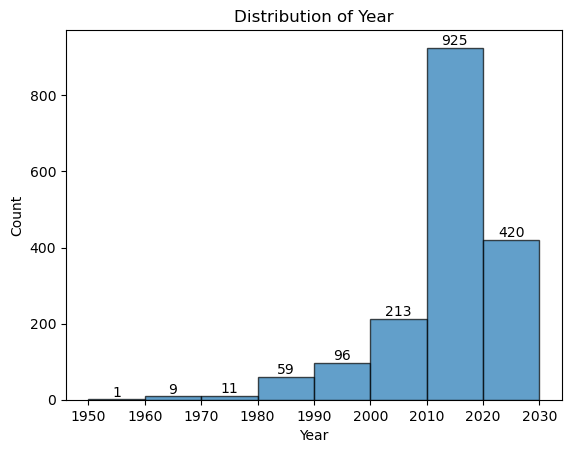

In [47]:
bin_edges = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
plot_histogram_with_counts(cleaned_movies_df, 'year', bin_edges, title='Distribution of Year')

This graph confirms that most of the movies are relatively recent, so our data will skew toward newer movies. But that's not necessarily a bad thing as ratings tend to change over time, so the more recent the data, the more accurate our predictions can be. We can also look at the distribution for each type of movie rating. 

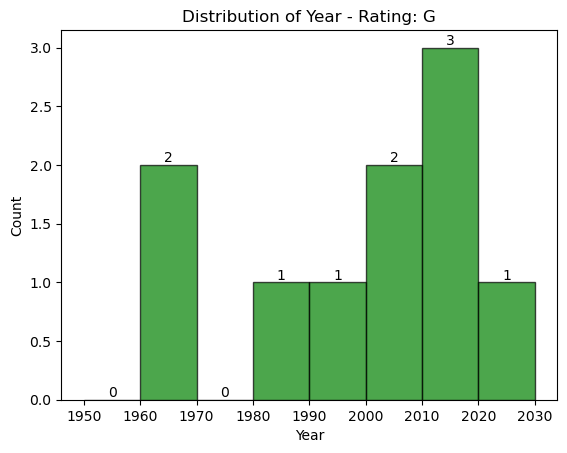

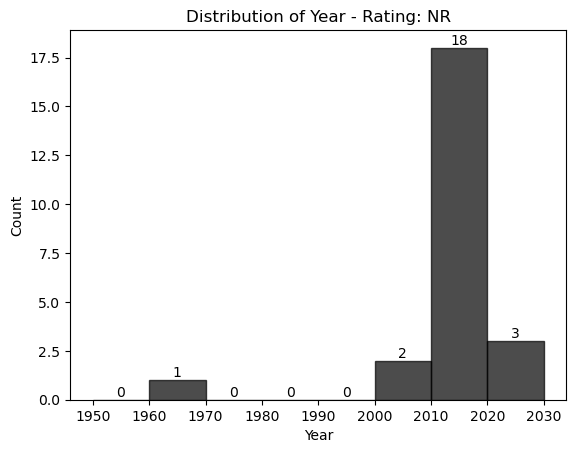

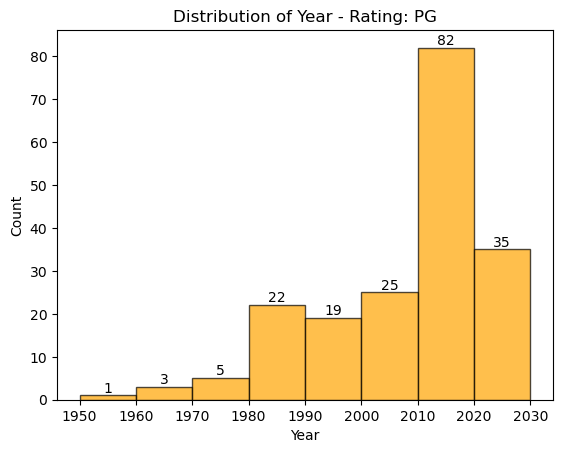

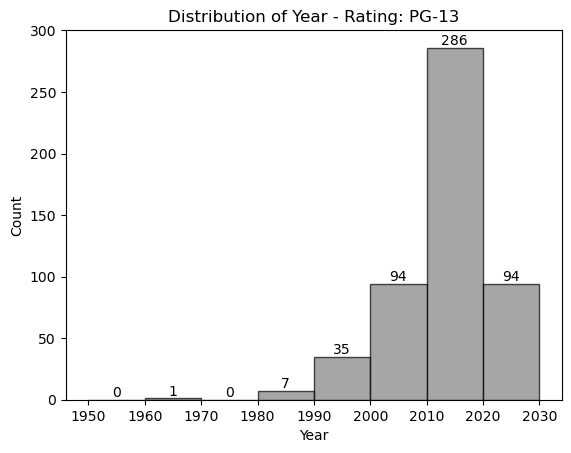

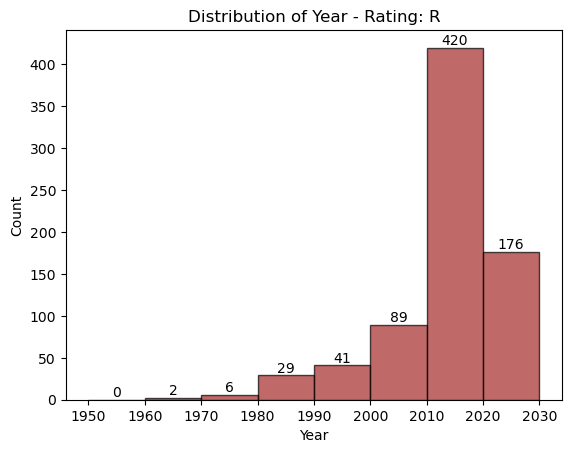

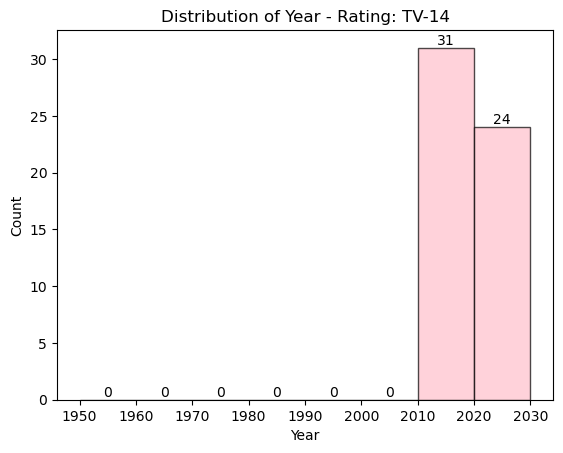

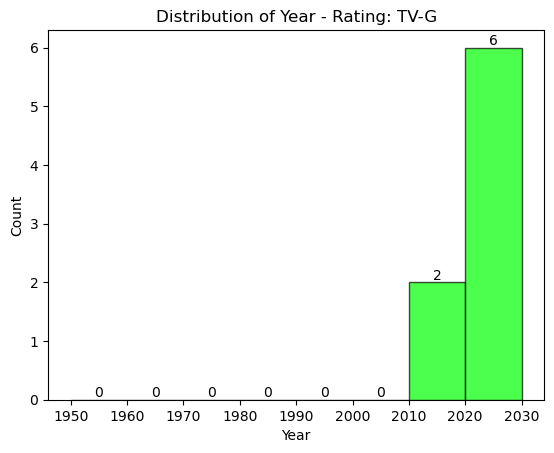

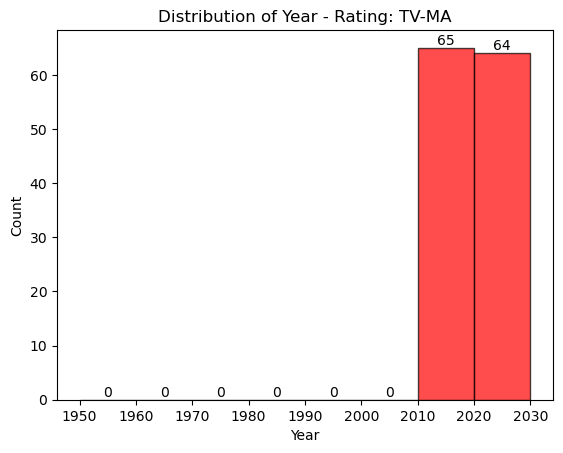

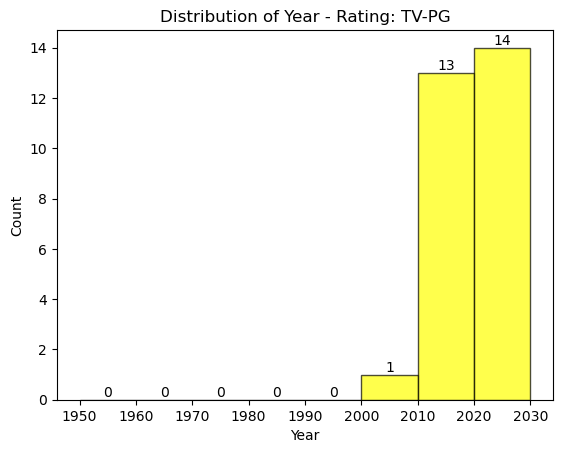

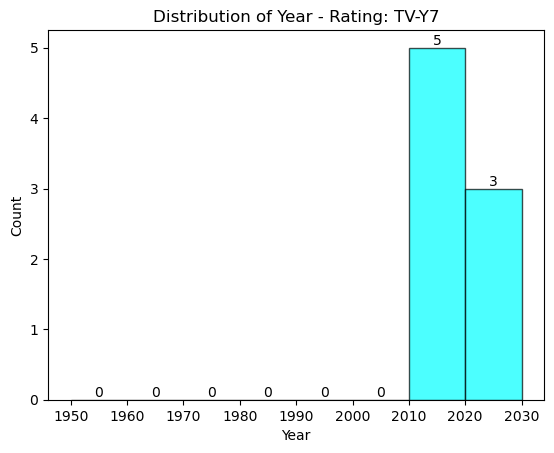

In [48]:
for mpaa_rating, group_df in cleaned_movies_df.groupby('mpaa_rating'):
    color = rating_colors.get(mpaa_rating, 'blue')  # Use blue as default color if rating not found in dictionary
    plot_histogram_with_counts(group_df, 'year', title='Distribution of Year',title_suffix=' - Rating: '+mpaa_rating, color=color, bin_edges=bin_edges)

All the ratings seem to be skewed as well toward the 2010-2020 period which tracks with our overall numbers. The two that seem to be ratioed the most to older movies are PG and PG-13, but they still follow the general trend. 

### Rating<a id='Rating'>

Let's now look at the Ratings. 

In [49]:
cleaned_movies_df.mpaa_rating.describe()

count     1734
unique      10
top          R
freq       763
Name: mpaa_rating, dtype: object

R is the most common rating we have in our dataset. Let's look at the full distribution. 

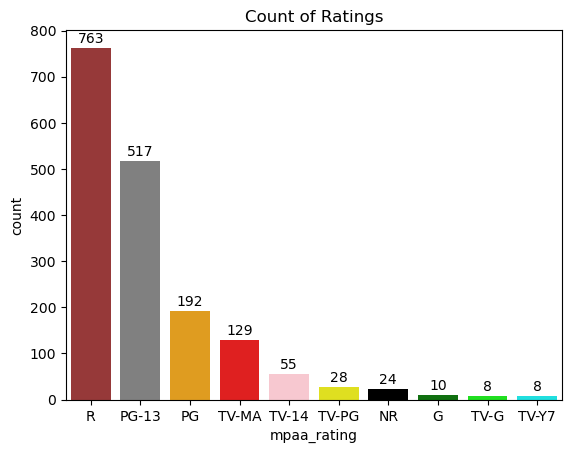

In [50]:
#def countplot(data,column,bars=10, hue=None,legend_title=None,legend=True):
countplot_x(cleaned_movies_df, 'mpaa_rating', palette = rating_colors,legend=False, title='Count of Ratings')

Looking at the counts of ratings, we see R and PG-13 are the most common from our dataset. We don't have as many TV ratings as we do movie ratings, so it may make sense to combine them at some point, but we'll leave them as separate for now. 

### Duration <a id='Duration'>

Let's now look at Duration. 

In [51]:
cleaned_movies_df.duration_sec.describe()

count     1734.000000
mean      6500.199539
std       1070.351719
min       1943.000000
25%       5760.000000
50%       6360.000000
75%       7080.000000
max      12540.000000
Name: duration_sec, dtype: float64

We see that the average movie duration is 6500 seconds which is around 108 minutes. This is also a common movie time for most movies that come out these days so that average makes sense. The longeset movie is 12540 which is around a 3.5 hour movie. The shortest movie is around 30 minutes which would be more around a TV show length. That does make sense since there are some TV show ratings mixed in. Let's look at the full distribution. 

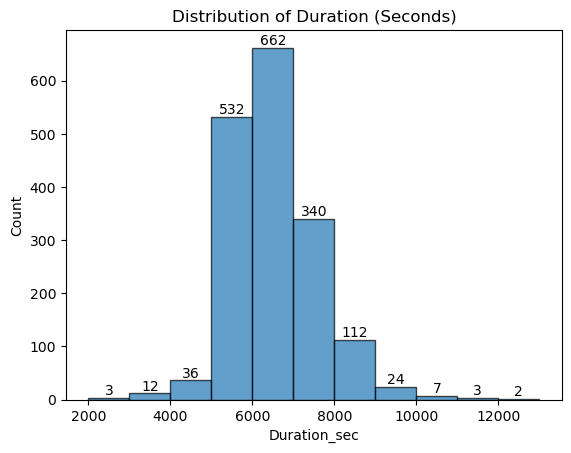

In [52]:
bin_edges = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000,13000]
plot_histogram_with_counts(cleaned_movies_df, 'duration_sec',bin_edges=bin_edges, title='Distribution of Duration (Seconds)')

We see it mimics a normal distribution for the duration of these movies. Here is a breakdown to help interpret the results:

    2000 sec = 33 minutes
    4000 sec = 1 hour 7 minutes
    6000 sec = 1 hour 40 minutes
    8000 sec = 2 hour 13 minutes
    10000 sec = 2 hour 47 minutes
    12000 sec = 3 hours 20 minutes

Let's now look at the duration for each rating.

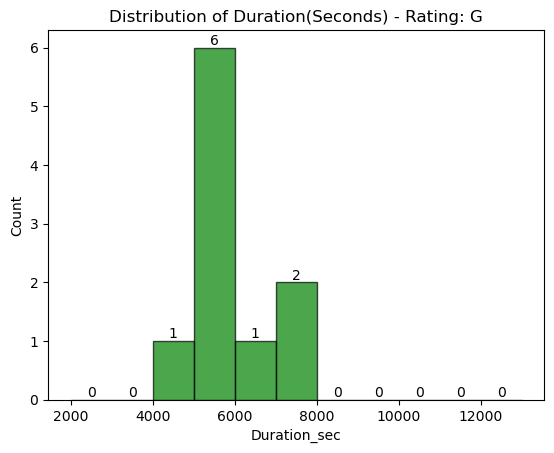

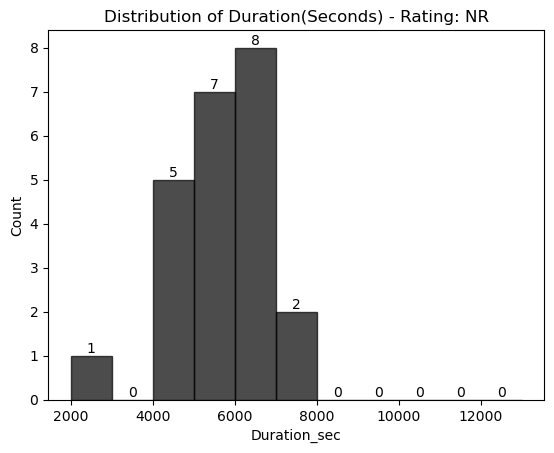

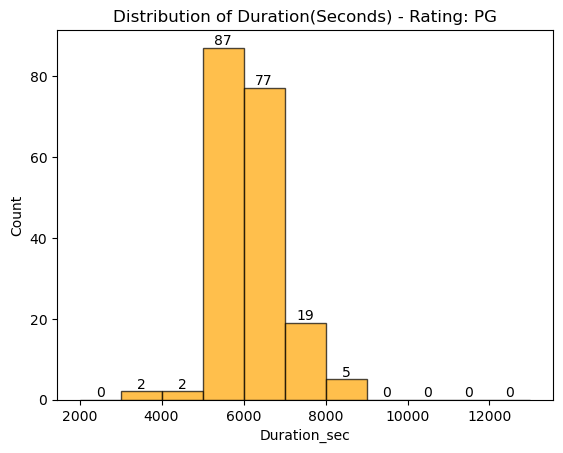

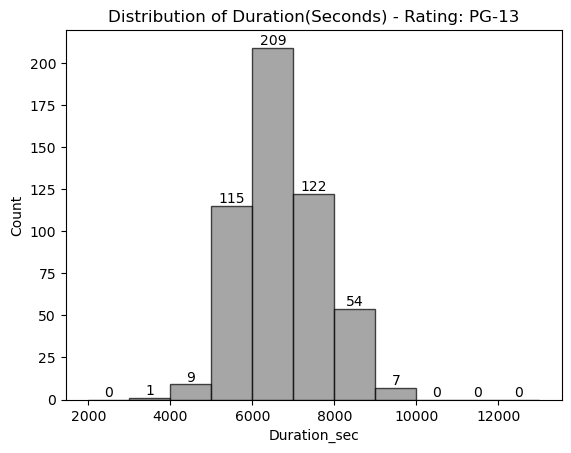

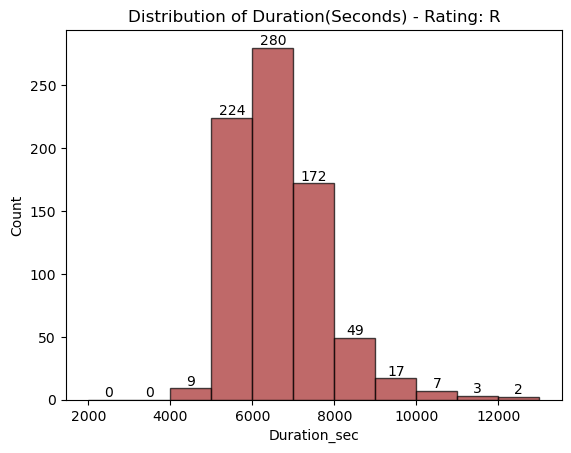

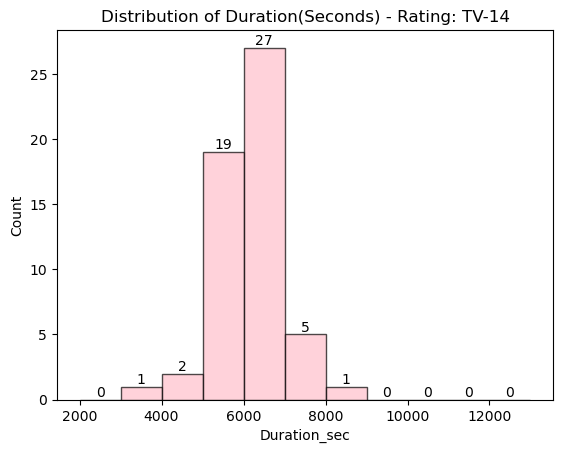

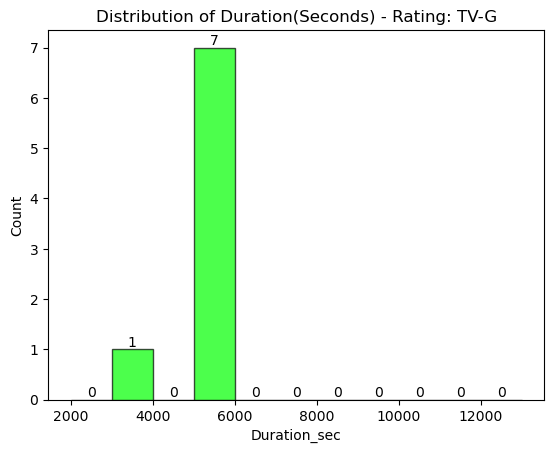

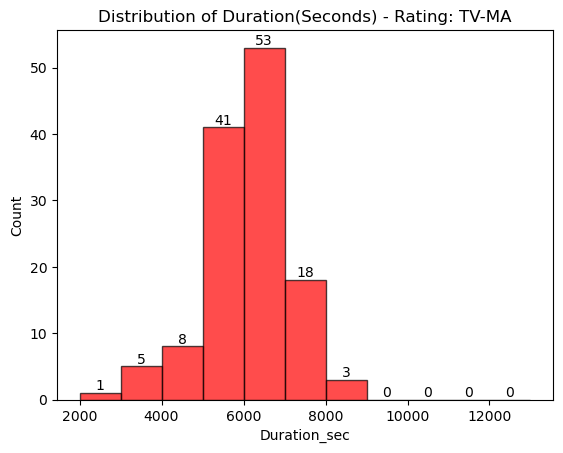

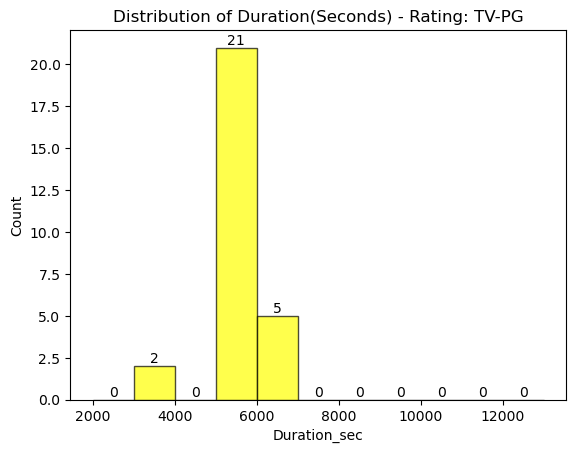

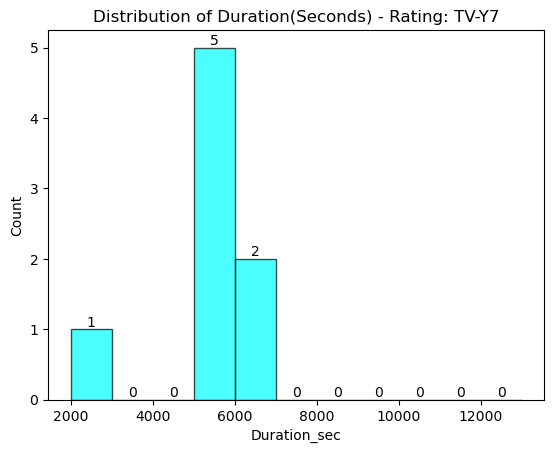

In [53]:
for mpaa_rating, group_df in cleaned_movies_df.groupby('mpaa_rating'):
    color = rating_colors.get(mpaa_rating, 'blue')  # Use blue as default color if rating not found in dictionary
    plot_histogram_with_counts(group_df, 'duration_sec', title='Distribution of Duration(Seconds)',title_suffix=' - Rating: '+mpaa_rating, color=color, bin_edges = bin_edges)

We see the TV ratings tend to be shorter in length but still have peaks around the mean. We see that R ratings tend to skew longer. So a trend that could be argued is that if a movie is longer, it has a higher liklihood of having a more severe rating (PG-13/R). 

### Studios <a id='Studios'>

Let's now take a look at the studios. Previously in our cleaning step, we found that there were many studios that worked together on movies which resulted in movies having multiple studios hidden within the studio column. We had broken them up in our cleaning step into a dataframe that split out specifically the studios for each movie, as well as the rating. Here it is for reference.

In [54]:
split_studios_cleaned_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,mpaa_rating
name,,,,,,,,,,,,,,,,,,,
The Out-Laws,Happy Madison Productions,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Extraction 2,Other,AGBO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Air,Mandalay Pictures,Amazon Studios,Skydance,Other,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Bird Box Barcelona,Nostromo Pictures,Other,Other,Other,None,None,None,None,None,None,None,None,None,None,None,None,None,None,TV-MA
Top Gun: Maverick,Paramount,Jerry Bruckheimer Films,None,Other,Tencent Pictures,Skydance,None,None,None,None,None,None,None,None,None,None,None,None,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guns Akimbo,Ingenious Media,Other,Other,Other,Other,Other,Other,Other,None,None,None,None,None,None,None,None,None,None,R
Cop Car,Universal Pictures,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R
Mr. Right,Focus,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,R


In our cleaning step, we had updated the studios with the new mapping for similar studios, then removed any duplicates, and then replaced unique studios with 'Other'. Now that we have the updated studios, we can melt the table so there is one row per studio with the rating of that movie. Using the movie Extraction 2 as an example, we see it has two studios, Other and AGBO. We will create two rows for this movie, one for each studio as well as the rating. This will allow us to look at the distribution of movies for each studio. Some movies may have multiple 'Other' studios, but this is still valid as those would be separate studios if we didn't classify them as 'Other'. 

In [55]:
melted_studios = split_studios_cleaned_df.melt(id_vars='mpaa_rating', value_name='studio').drop(columns='variable')
melted_studios = melted_studios[melted_studios['studio'] != '']
filtered_melted_studios = melted_studios[melted_studios['studio'].notna()]
filtered_melted_studios

,mpaa_rating,studio
0,R,Happy Madison Productions
1,R,Other
2,R,Mandalay Pictures
3,TV-MA,Nostromo Pictures
4,PG-13,Paramount
...,...,...
23030,R,Other
24764,R,Other
26498,R,Movistar+
28232,R,Other


After melting the table, we see there are 2990 rows for all the studios in our dataset. The same movie can have multiple rows here, but all we care about for this part of the analysis is the rating for each studio. Let's look at the counts for each studio. 

In [56]:
studio_counts = filtered_melted_studios['studio'].value_counts() 
studio_counts

Other                   1311
Universal Pictures       225
Paramount                170
Sony                     147
Lions Gate               103
                        ... 
Tyler Perry Studios        3
Screen Arcade              3
87Eleven Productions       3
Material Pictures          3
Movistar+                  3
Name: studio, Length: 169, dtype: int64

We see the studio with the most movies is Other with 1311 which makes sense as there are a lot of studios only represented a couple times. The first studio that is not Other is Universal Pictures with a count of 225. We see there are 168 movie studios with 3 or more movies. Let's take a look at the top 12 studios and see how many they have. 

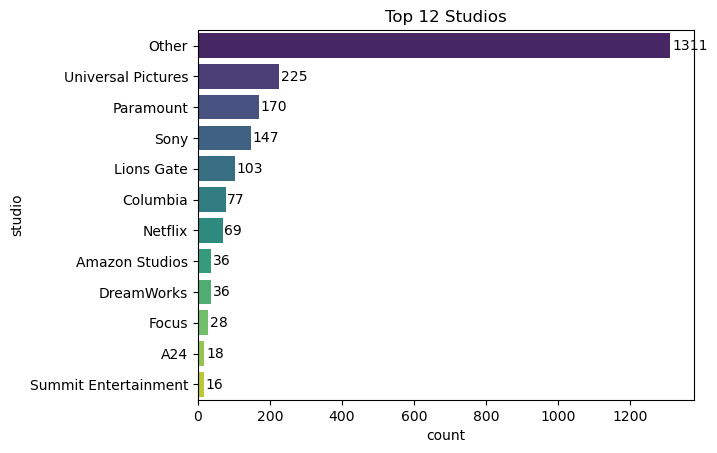

In [57]:
top_n = 12
countplot_y(filtered_melted_studios,'studio',bars=top_n,legend=False,palette='viridis', title='Top '+str(top_n)+' Studios')

After the top 6 (not including Other), the number of movies drops to below 50 movies. Let's look at the distribution of ratings for these top 12 studios. 

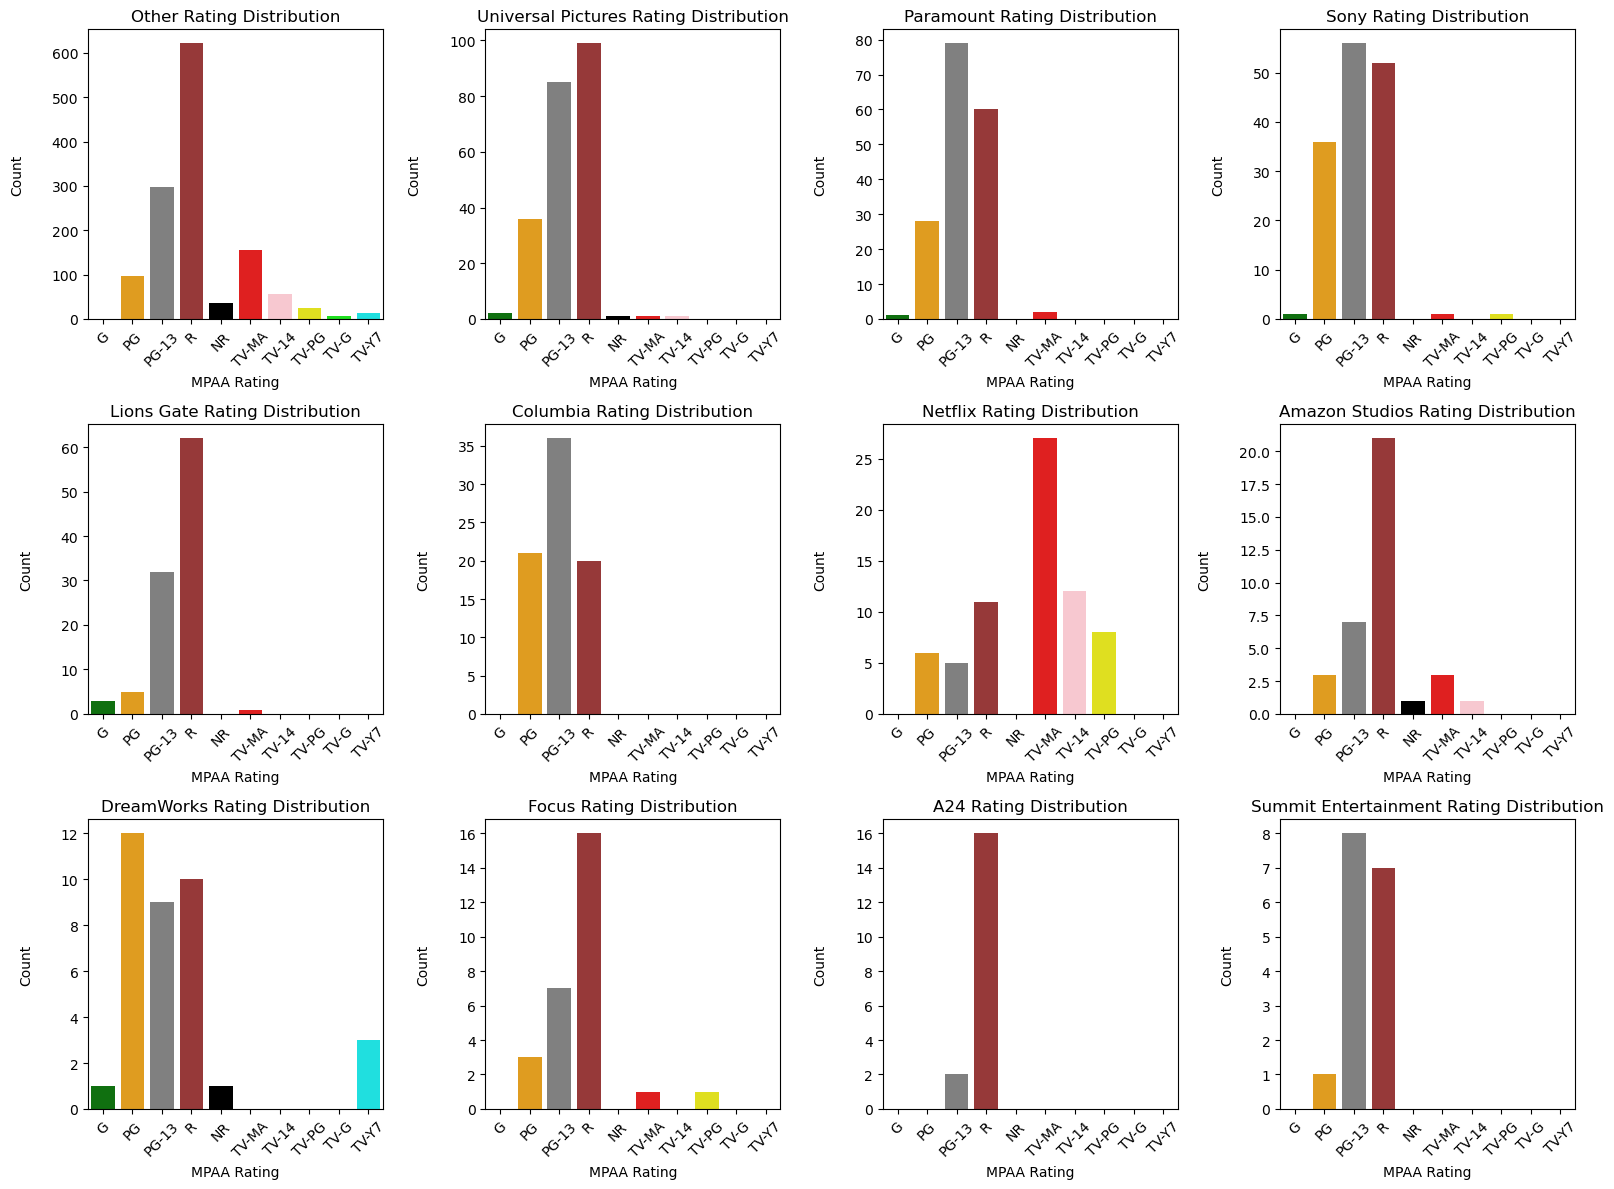

In [58]:
# Define a custom color palette for the rating categories
rating_order = ['G', 'PG', 'PG-13', 'R', 'NR', 'TV-MA', 'TV-14', 'TV-PG', 'TV-G', 'TV-Y7']

# Select the top N studios based on counts
top_studios = studio_counts.nlargest(top_n)

# Determine the number of rows and columns for the grid
n_cols = 4
n_rows = math.ceil(top_n / n_cols)

# Create the main figure for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Loop through each top studio and create a count plot for each rating category
for i, (studio, ax) in enumerate(zip(top_studios.index, axes.flatten())):
    studio_data = filtered_melted_studios[filtered_melted_studios['studio'].str.contains(studio, na=False)]
    
    sns.countplot(data=studio_data, x='mpaa_rating', palette=rating_colors, ax=ax, order=rating_order)
    ax.set_title(f'{studio} Rating Distribution')
    ax.set_xlabel('MPAA Rating')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.yaxis.labelpad = 20

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the entire grid of subplots
plt.show()

We see for the majority of studios, R is the most common rating among them with PG-13 coming in second. This matches the expected distribution we were seeing when looking at the ratings holistically. One interesting note is with Netflix where a majority of the movies are TV-MA as opposed to R like most of the other studios. 

### Number of Studios <a id='number_of_studios'>

Let's see if any trends lie in the number of studios. 

In [59]:
cleaned_movies_df['number_of_studios'].describe()

count    1734.000000
mean        1.717993
std         1.473188
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        18.000000
Name: number_of_studios, dtype: float64

We see that the average is at 1.7 studios, so most have between 1 and 2 studios. The most stuidos a movie had was 18 but it doesn't seem to be very common based on the overall statistics of the data. Let's now look at the counts for each of the different number of studios. 

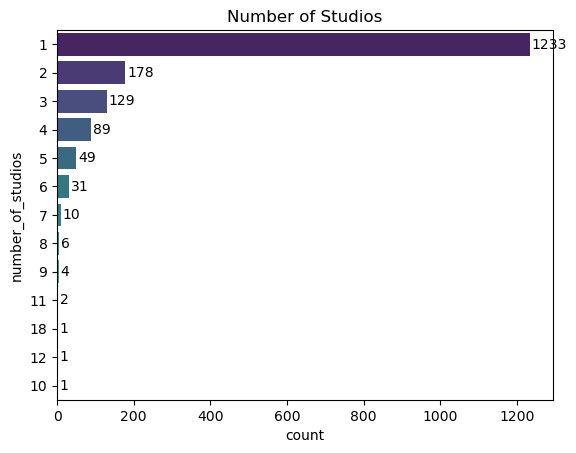

In [60]:
countplot_y(cleaned_movies_df,'number_of_studios',bars=15,legend=False,palette='viridis', title='Number of Studios')

As suspected, 1 and 2 are the top two numbers of studios, with 1 having a majority of the total data. The really high studio counts are a lot less common, so those won't be as useful in the analysis. Let's now look at if there are any trends with the rating for number of studios. 

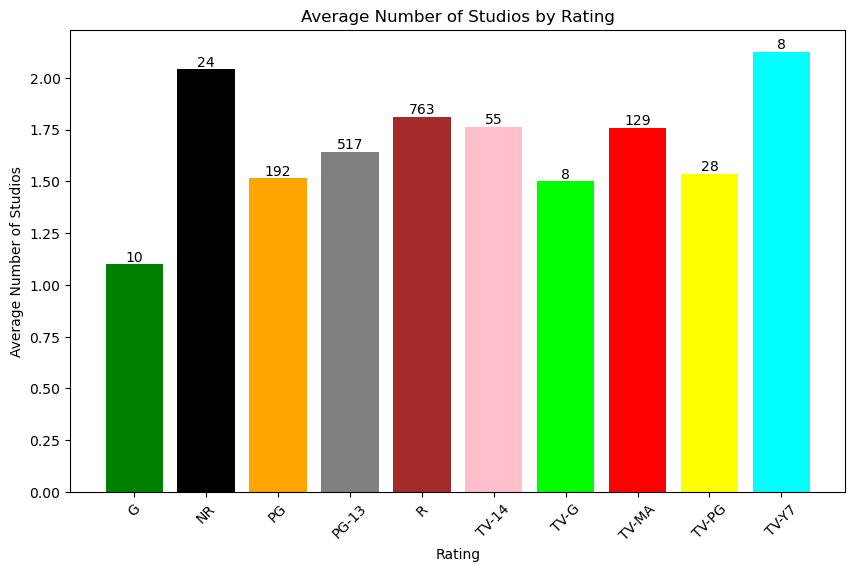

In [61]:
# Group the DataFrame by 'mpaa_rating' and calculate both the mean number of studios and the count of movies
rating_studios_avg = cleaned_movies_df.groupby('mpaa_rating')['number_of_studios'].mean().reset_index()
rating_movie_count = cleaned_movies_df['mpaa_rating'].value_counts().reset_index()
rating_movie_count.columns = ['mpaa_rating', 'movie_count']

# Merge the two DataFrames on 'mpaa_rating'
rating_data = pd.merge(rating_studios_avg, rating_movie_count, on='mpaa_rating')

# Create a bar plot to visualize the relationship with custom colors
plt.figure(figsize=(10, 6))
plt.bar(
    rating_data['mpaa_rating'],
    rating_data['number_of_studios'],
    color=[rating_colors.get(rating, 'blue') for rating in rating_data['mpaa_rating']]
)
plt.xlabel('Rating')
plt.ylabel('Average Number of Studios')
plt.title('Average Number of Studios by Rating')
plt.xticks(rotation=45)

# Adding the count of total movies as text on top of the bars
for i, count in enumerate(rating_data['movie_count']):
    plt.text(i, rating_data['number_of_studios'][i] , f'{count}', ha='center', va='bottom')

plt.show()

We see overall, there isn't much of a trend in regards to average number of studios and a specific rating type. Some of the ones with less volume in our data are more on the extremes, but everything falls right around the average with no particular outliers. This shows that regardless of the type of movie, studios can collaborate with each other.

Now we have gone through all the columns in our cleaned movies dataframe, so let's now look at the movie tags. 

## Movie Tags <a id='Movie_Tags_EDA'>

As a reminder for movie tags, we have a dataframe that includes a row for each type of tag in a movie and includes how many times it has occurred in the movie as well as how long it occurred. A movie may have multiple rows if there are multiple tags for that movie.

In [62]:
movie_tags

,imdb_id,category,tag_name,occurrence_cnt,duration_sec
0,tt0052357,language,blasphemy,1,0.1
1,tt0052357,violence,non_graphic,5,30.0
2,tt0052357,violence,disturbing_images,1,0.1
3,tt0052357,immodesty,immodesty,1,6.0
4,tt0052357,immodesty,nudity_implied,1,30.0
...,...,...,...,...,...
23975,tt9902160,violence,non_graphic,9,18.0
23976,tt9902160,violence,graphic,4,12.0
23977,tt9902160,immodesty,immodesty,3,30.0
23978,tt9902160,sexual,sexually_suggestive,1,6.0


Let's first take a look at the category column. 

### Category <a id='Category'>

The category column is the general field a tag falls in and categorizes them. Here are the different categories that can be used:

    language
    violence
    immodesty
    sexual
    drugs
    other

Let's see what the most frequent category is.

In [63]:
movie_tags.category.describe()

count        23980
unique           6
top       language
freq          6168
Name: category, dtype: object

We see Language is the most common category, but it makes up around 25% of the data, so there is a relatively even distribution among all the categories. Let's look at the exact counts. 

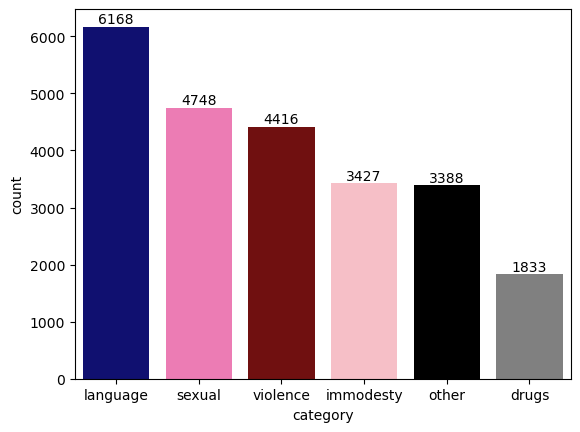

In [64]:
countplot_x(movie_tags,'category', hue=None,palette=category_colors,legend_title=None,legend=False)

It looks like after language, all of sexual, violence, immodesty, and other are around similar levels, with drugs having the fewest amount in this dataset. Let's now take a look at the tag names to see if there are any trends when getting more specific into the type of tag. 

### Tag Name <a id= 'tag_name'>

Let's first take a look at the counts for each tag name. 

In [65]:
movie_tags['tag_name'].value_counts()

blasphemy              1658
profanity              1652
non_graphic            1632
immodesty              1487
sexual_reference       1452
graphic                1248
kissing_normal         1111
sexually_suggestive    1052
bodily_functions       1048
nudity_without_sex      920
childish_language       880
disturbing_images       870
objectionable           827
kissing_passion         798
sex_implied             742
drugs_implied           640
drugs_legal             639
vulgar_gestures         597
drugs_illegal           554
nudity_implied          542
racial_slurs            526
nudity_art              478
sexual_assault          473
gore                    379
sex_without_nudity      345
medical_graphic         322
medical_procedures      301
life_events             293
violence_implied        287
sex_with_nudity         227
Name: tag_name, dtype: int64

Blasphemy and profanity are the top two which are both under language which explains why that one is the most common category. We see a steady decline of the counts for each of the different tag names, but enough data for them to be considered in our analysis. 

In [66]:
movie_tags.tag_name.describe()

count         23980
unique           30
top       blasphemy
freq           1658
Name: tag_name, dtype: object

Let's now take a look at all the different categories that these fall into. I will look at the top 15 of the 30 tag names that we have to get an idea of where the majority fall. 

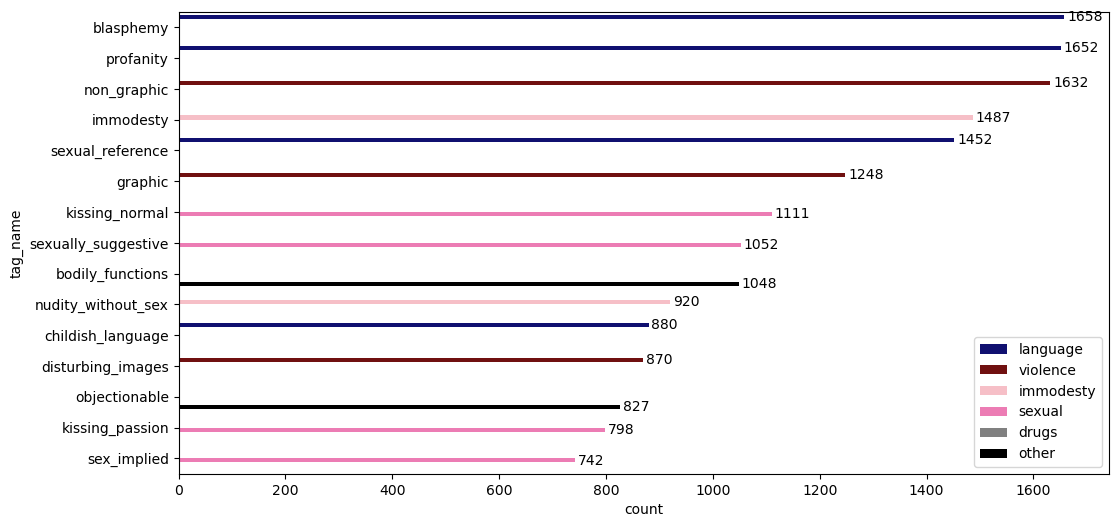

In [67]:
plt.figure(figsize=(12, 6))
countplot_y(movie_tags,'tag_name', bars = 15, hue='category',palette=category_colors,legend_title=None,legend=True)

We see that 4/15 are language, 3/15 are violence, 2/15 are immodesty, 4/15 are sexual, 0/15 are drugs, and 2/15 are other. A pretty even mix except for drugs not being represented which makes sense since that is the lowest of the categories. Now let's look at Occurrence Count. 

### Occurrence Count <a id='occurrence_cnt'>

The Occurrence Count is the number of times the tag occurs in a movie. For example, a movie may have multiple bad words said, so each instance would count as an occurance. Let's take a look at the breakdown of the occurences. 

In [68]:
movie_tags.occurrence_cnt.describe()

count    23980.000000
mean        12.620225
std         28.444183
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max        883.000000
Name: occurrence_cnt, dtype: float64

We see the average is just over 12 occurances for each tag. However, we see that 75% of the data falls within 1-12, so our average is skewed by the high amounts. We see it maxes out at 883 occurrances, but the typical counts are most likely on the lower end. Let's look at the top 30 counts that we have for occurrences. 

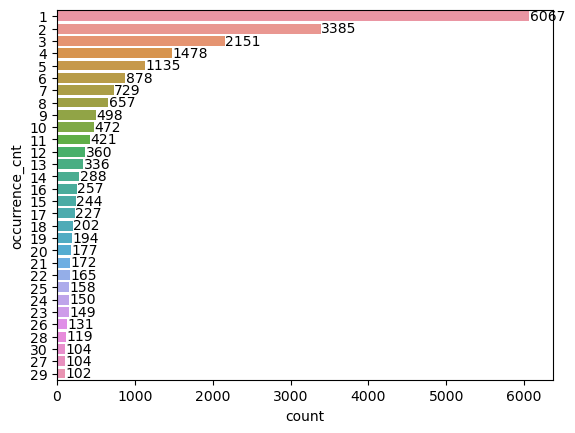

In [69]:
countplot_y(movie_tags,column='occurrence_cnt',bars=30,legend=False)

We see that the most common occurence count is 1 and the top 10 are the counts 1-10 which makes sense for why 75% of the data skews on the lower half. Let's compare the occurence counts to the duration column and see if we can find any useful insights. 

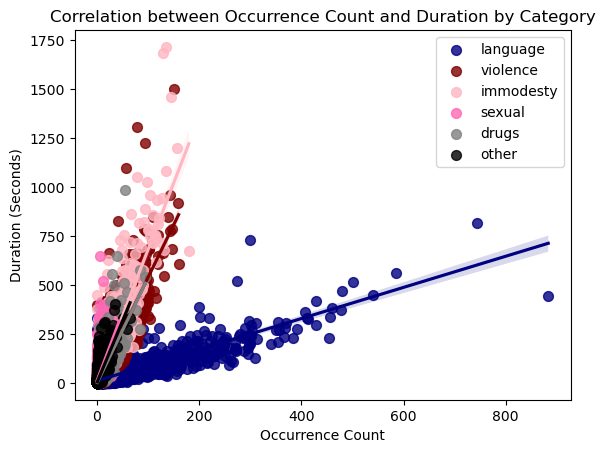

In [70]:
# Iterate through each category and plot separate scatter plots
for category in movie_tags['category'].unique():
    category_data = movie_tags[movie_tags['category'] == category]
    category_color = category_colors.get(category, 'blue')  # Use 'blue' as default color if category not found in dictionary
    sns.regplot(x='occurrence_cnt', y='duration_sec', data=category_data, scatter_kws={'s': 50, 'color': category_color}, line_kws={'color': category_color},label=category)

plt.xlabel('Occurrence Count')
plt.ylabel('Duration (Seconds)')
plt.title('Correlation between Occurrence Count and Duration by Category')
plt.legend()
plt.show()

We can see from the above graph that if there is a high occurrence count, the tag will most likely have the category of language. These ones will also not have as high of a duration. For all the other categories, their occurrence counts are much smaller, but the duration tends to be higher. So our model may be able to make some predictions regarding these trends where if there is a high occurrence count, it will consider it a language category which may help in determining the rating. Let's look at Duration a bit more. 

### Duration (Seconds) <a id='duration_sec'>

The duration is how long the tag occurs for in a movie. For some types of tags, it may be happening throughout an entire scene which may cause it to have a long duration. Othertimes, it may happen quickly and have a short duration. Let's look at some of the statistics behind it. 

In [71]:
movie_tags.duration_sec.describe()

count    23980.000000
mean        45.823057
std         84.703623
min          0.100000
25%          6.000000
50%         18.000000
75%         48.000000
max       1716.000000
Name: duration_sec, dtype: float64

We see that the average duration is around 45 seconds, but 50% of the data falls within 6 and 48 seconds. This means our average is affected by long duration outliers. The max is 1716 seconds (28.6 minutes) which shows there are some outliers. Let's try to review a histogram to see where everything is concentrated. 

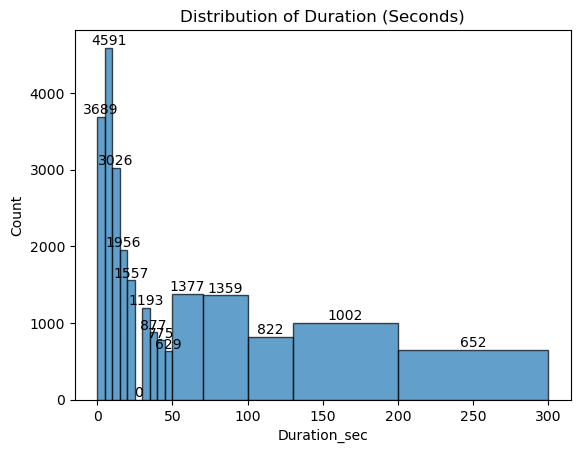

In [72]:
bin_edges = [ 0, 5, 10, 15, 20, 25, 30,35, 40,45, 50,70,100,130,200,300]
#plt.xlim(0, 300)
#take the log
plot_histogram_with_counts(movie_tags, 'duration_sec', title='Distribution of Duration (Seconds)', bin_edges=bin_edges)

Due to the long and uneven distribution for the duration, I had to get a bit creative with the buckets for the histogram. We see there are a lot of extremely short durations where a majority of the data is under 50 seconds. Under 50, I did buckets every 5 seconds so a lot of short durations. As the duration gets longer, there are less and less occurrences so the buckets became bigger. After 50, I increased the buckets by 20, 30, 70, and 100 seconds respectively. We see similar numbers as a result. Ultimately, what this is telling us is that most of the durations are short and concentrated under 50 seconds. Let's now explore some of the outliers with durations are over 1000 seconds. 

In [73]:
movie_tags[movie_tags.duration_sec > 1000]

,imdb_id,category,tag_name,occurrence_cnt,duration_sec
1415,tt0105236,violence,graphic,57,1098.0
6399,tt1034415,immodesty,nudity_without_sex,79,1050.0
6908,tt1078940,immodesty,immodesty,145,1458.0
7002,tt10954652,immodesty,immodesty,98,1026.0
7932,tt11804152,violence,graphic,151,1500.0
8638,tt12676326,immodesty,immodesty,130,1686.0
9289,tt13320622,immodesty,immodesty,156,1200.0
11026,tt1564367,immodesty,immodesty,136,1080.0
15150,tt3072482,violence,graphic,95,1224.0
15717,tt3460252,violence,graphic,78,1308.0


There are only 11 tags that are over 1000 seconds in duration, and they all are either graphic violence or immodesty. Both of these make sense since violence can be attributed to any extended action scene, while immodesty can correspond to anyone in a scene that is wearing skimpy outfits. Let's now review to see if there are any durations where category is a factor. 

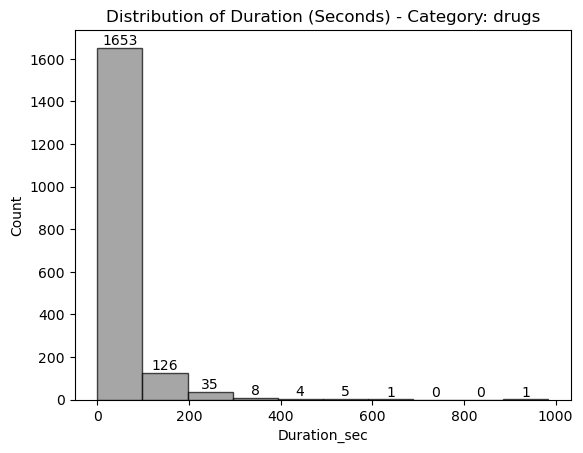

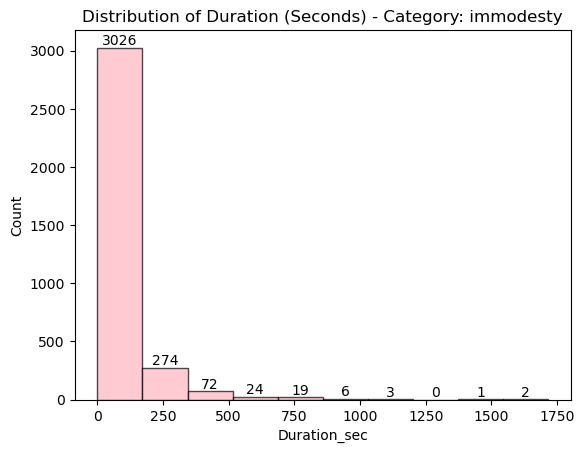

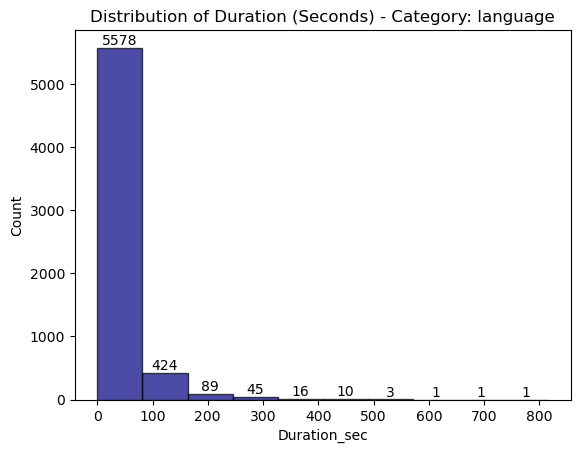

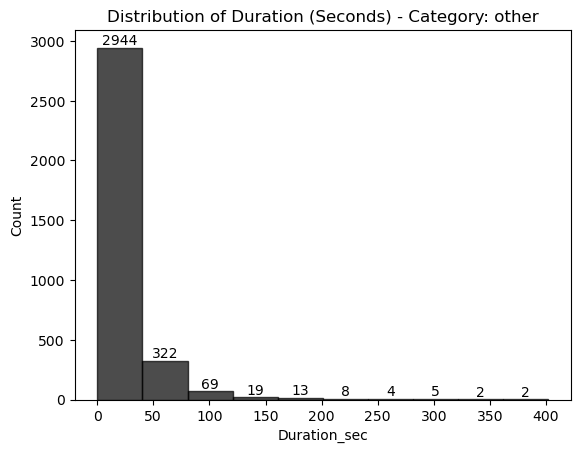

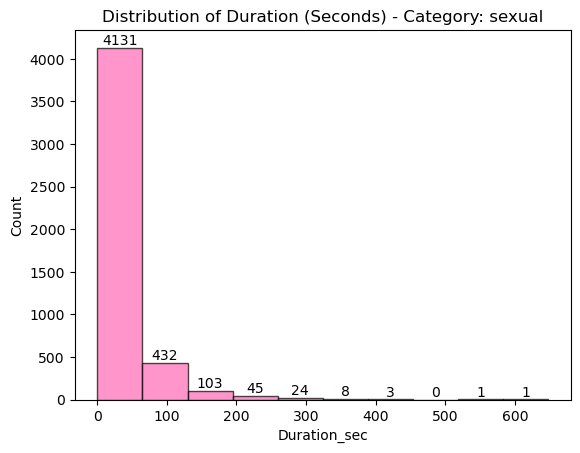

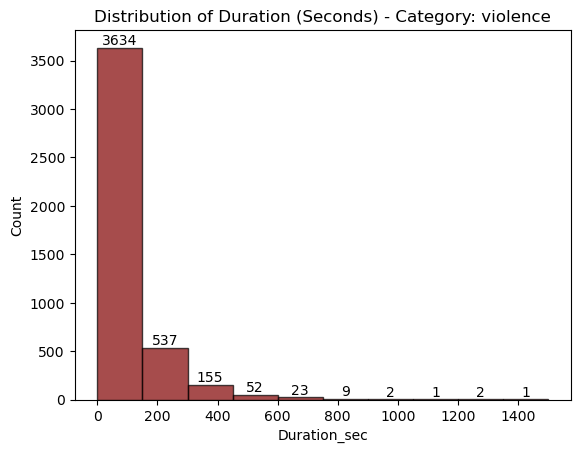

In [74]:
for category, group_df in movie_tags.groupby('category'):
    color = category_colors.get(category, 'blue')  # Use blue as default color if rating not found in dictionary
    plot_histogram_with_counts(group_df, 'duration_sec', title='Distribution of Duration (Seconds)',title_suffix=' - Category: '+category, color=color)

Language has by far the most short durations, but Other and Sexual also have really short durations as it doesn't have many that go for as long as the others. All of them are concentrated under taht 200 second mark (3.33 minutes) so most of the time all these categories are happening in short spurts throughout movies. 

# Save the Data <a id='Save_the_Data'>

Now that we have finished exploring our data, we will save our cleaned up dataframes so they are ready to use for our preprocessing and modeling steps. In this notebook, we were able to cleanup our data to allow for better analysis, and we were able to analyze our data to make some valuable insights into what potential factors could be going into these ratings. In the next notebook, we will get our data ready for modeling and run the data through some models to make some predictions. 

In [75]:
#Save the modified dataframe to a new .csv file called clean_data.csv
tags.to_csv("data/clean_data/cleaned_tags.csv", index=False)
cleaned_movies_df.to_csv("data/clean_data/cleaned_movies.csv", index=False)
movie_tags.to_csv("data/clean_data/cleaned_movie_tags.csv", index=False)